# DATA 620 - Final Project

Jeremy OBrien, Mael Illien, Vanita Thompson

## Topic Networks

### Introduction

A powerful analytical application of NLP is topic modeling, which identifies the themes present in a corpus comprised of multiple documents based on the words in those documents. Because it can be used to uncover the thematic structure in documents, topic modeling has an array of applications in information retrieval and document mining.

Topics are 'probability distributions over a fixed vocabulary'. An overview of topic modeling and its current applications in bioinformatics, and it's common to use probabilistic generative models derived from LDA (Latent Dirichlet Allocation) to model in an unsupervised fashion the latent semantic structure of documents. Topic models can be tuned and optimized in a variety of ways, including improving how topics are segregated from each other and calibrating for a useful number of topics.

### Research Question
We will combine techniques from topic modeling and network analysis to address this question.

Given a text corpus comprised of multiple documents, what are the topics of those documents and how are the documents thematically related to one another?

### Approach
- Leverage the Reuters news corpus of nearly 11,000 articles (labeled with at least one category each; unfortunately, authorship is not labeled)
- Using the NLTK, Spacy, and Gensim packages, implement and tune an unsupervised LDA-based topic model (i.e. without reference to the provided article topic labels)
- Analyze model perplexity and coherence, overall topic prevalence, and topic distribution across articles
- Generate a bipartite, weighted (likely on coherence) graph of articles and topics, and analyze its topology to identify relationships between topics

## Setup

In [1]:
import re
import random
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
from nltk.corpus import stopwords
from nltk.corpus import reuters

import spacy  # need to install

import gensim  # need to install
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
# warnings.filterwarnings('ignore', category=DeprecationWarning)

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

## Data Import & Processing

### Data import and preliminary EDA

In [2]:
# NLTK Reuters corpus test
from nltk.corpus import reuters
reuters.fileids()
reuters.words('test/14841')[-10:]

['the', 'shipment', 'was', 'for', 'April', '8', 'to', '20', 'delivery', '.']

Here are 25 sampled categoies from the Reuters corpus. These correspond to themes/topics assigned to documents in the corpus and are essentially labels for the articles.

In [3]:
# Remove
random.choices(reuters.categories(),k=25)

['yen',
 'meal-feed',
 'hog',
 'interest',
 'platinum',
 'cpu',
 'jet',
 'palm-oil',
 'rubber',
 'interest',
 'money-fx',
 'veg-oil',
 'naphtha',
 'fuel',
 'copra-cake',
 'zinc',
 'zinc',
 'yen',
 'jobs',
 'sun-oil',
 'copra-cake',
 'rice',
 'palmkernel',
 'veg-oil',
 'palmkernel']

In [4]:
# Adjust to generate dataframe directly from nltk corpus
# https://stackoverflow.com/questions/46109166/converting-categorizedplaintextcorpusreader-into-dataframe
news = []
for fileid in reuters.fileids():
    tag, filename = fileid.split('/')
    news.append((filename, tag, reuters.categories(fileid), reuters.raw(fileid)))

df = pd.DataFrame(news, columns=['filename', 'tag', 'categories','text'])

In [5]:
# hide tag column
df

,filename,tag,categories,text
0,14826,test,[trade],ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...
1,14828,test,[grain],CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...
2,14829,test,"[crude, nat-gas]",JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...
3,14832,test,"[corn, grain, rice, rubber, sugar, tin, trade]",THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n ...
4,14833,test,"[palm-oil, veg-oil]",INDONESIA SEES CPO PRICE RISING SHARPLY\n Ind...
...,...,...,...,...
10783,999,training,"[interest, money-fx]",U.K. MONEY MARKET SHORTAGE FORECAST REVISED DO...
10784,9992,training,[earn],KNIGHT-RIDDER INC &lt;KRN> SETS QUARTERLY\n Q...
10785,9993,training,[earn],TECHNITROL INC &lt;TNL> SETS QUARTERLY\n Qtly...
10786,9994,training,[earn],NATIONWIDE CELLULAR SERVICE INC &lt;NCEL> 4TH ...


In [6]:
# Output with print
# Describe shape of data

# 10,788 separate cases (news articles)
# df.shape
# len(df.filename.unique())

# Each case is tagged as either train or test
# df.tag.unique()

# There are 10,657 articles with distinct text body - so 131 duplicates
# len(df.text.unique())

# Check the text body of duplicates (except for first instance)
# print(df[df.text.duplicated('first')])

# JO: Evaluate cause and consider case for removal
# MI: I checked with some of the indexes and found no overlap. See below

In [7]:
#print(df[df.text.duplicated('first')])

### Data cleaning and deduplication

In [8]:
# Convert to list
data = df['text'].values.tolist()

# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub(r"\'", "", sent) for sent in data]

pprint(data[330][:1000])

('G-7 ISSUES STATEMENT AFTER MEETING Following is the text of a statement by '
 'the Group of Seven -- the U.S., Japan, West Germany, France, Britain, Italy '
 'and Canada -- issued after a Washington meeting yesterday. 1. The finance '
 'ministers and central bank governors of seven major industrial countries met '
 'today. They continued the process of multilateral surveillance of their '
 'economies pursuant to the arrangements for strengthened economic policy '
 'coordination agreed at the 1986 Tokyo summit of their heads of state or '
 'government. The managing director of the International Monetary Fund also '
 'participated in the meeting. 2. The ministers and governors reaffirmed the '
 'commitment to the cooperative approach agreed at the recent Paris meeting, '
 'and noted the progress achieved in implementing the undertakings embodied in '
 'the Louvre Agreement. They agreed, however, that further actions will be '
 'essential to resist rising protectionist pressures, sustai

In [9]:
# only one example
pprint(data[333][:1000])

('JAPAN BUSINESS LEADERS SAY G-7 ACCORD IS WORRYING The leaders of two of '
 'Japans top business groups said in separate statements the Group of Seven '
 '(G-7) accord reached in Washington yesterday is of deep concern to Japan '
 'because it shows the major industrial nations regard the yens current level '
 'as appropriate. Eishiro Saito, chairman of the Federation of Economic '
 'Organizations (Keidanren), said the yens present rate is well above adequate '
 'levels. He did not elaborate. Takashi Ishihara, chairman of the Japan '
 'Committee for Economic Development, said the accord will not prevent the yen '
 'from rising further. "We do not understand why the G-7 approved present '
 'rates as the yen has risen excessively since the Paris accord," Ishihara '
 'said. G-7 members Britain, Canada, France, Italy, Japan, the U.S. And West '
 'Germany said in a statement they consider their currencies are now within '
 'ranges broadly consistent with economic fundamentals. Saito called 

### Text preparation and feature engineering

In [10]:
# Tokenize words and clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#truncate
print(data_words[0])

['asian', 'exporters', 'fear', 'damage', 'from', 'japan', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 'and', 'japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'asias', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen', 'and', 'officials', 'said', 'they', 'told', 'reuter', 'correspondents', 'in', 'asian', 'capitals', 'move', 'against', 'japan', 'might', 'boost', 'protectionist', 'sentiment', 'in', 'the', 'and', 'lead', 'to', 'curbs', 'on', 'american', 'imports', 'of', 'their', 'products', 'but', 'some', 'exporters', 'said', 'that', 'while', 'the', 'conflict', 'would', 'hurt', 'them', 'in', 'the', 'long', 'run', 'in', 'the', 'short', 'term', 'tokyos', 'loss', 'might', 'be', 'their', 'gain', 'the', 'has', 'said', 'it', 'will', 'impose', 'mln', 'dlrs', 'of', 'tariffs', 'on', 'imports', 'of', 'japanese', 'electronics', 'goods', 'on', 'april', 'in', 'retaliation', 'for', 'japans', 'alleged', 'failur

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['asian', 'exporters', 'fear', 'damage', 'from', 'japan', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 'and', 'japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'asias', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen', 'and', 'officials', 'said', 'they', 'told', 'reuter_correspondents', 'in', 'asian', 'capitals', 'move', 'against', 'japan', 'might', 'boost', 'protectionist_sentiment', 'in', 'the', 'and', 'lead', 'to', 'curbs', 'on', 'american', 'imports', 'of', 'their', 'products', 'but', 'some', 'exporters', 'said', 'that', 'while', 'the', 'conflict', 'would', 'hurt', 'them', 'in', 'the', 'long', 'run', 'in', 'the', 'short_term', 'tokyos', 'loss', 'might', 'be', 'their', 'gain', 'the', 'has', 'said', 'it', 'will', 'impose', 'mln', 'dlrs', 'of', 'tariffs', 'on', 'imports', 'of', 'japanese', 'electronics', 'goods', 'on', 'april', 'in', 'retaliation', 'for', 'japans', 'alleged_failure', 'to', 's

### Pre-processing

In [12]:
# Set up stopwords
stop_words = stopwords.words('english')

# JO: Confirm if these / other stopwords should be added
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Remove stop words
data_words_nostops = remove_stopwords(data_words)

# Form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [15]:
print(data_lemmatized[0])

['asian', 'exporter', 'fear', 'damage', 'mount', 'trade', 'friction', 'raise', 'fear', 'many', 'asia', 'export', 'nation', 'row', 'could', 'inflict', 'far', 'reach', 'economic', 'damage', 'businessman', 'official', 'say', 'tell', 'asian', 'capital', 'move', 'may', 'boost', 'protectionist_sentiment', 'lead', 'curb', 'american', 'import', 'product', 'exporter', 'say', 'conflict', 'would', 'hurt', 'long', 'run', 'tokyos', 'loss', 'may', 'gain', 'say', 'impose', 'dlrs', 'import', 'japanese', 'electronic', 'good', 'retaliation', 'stick', 'pact', 'sell', 'semiconductor', 'world', 'market', 'cost', 'unofficial', 'japanese', 'estimate', 'put', 'impact', 'tariff', 'dlrs', 'spokesman', 'major', 'electronic', 'firm', 'say', 'would', 'virtually', 'halt', 'export', 'product', 'hit', 'new', 'taxis', 'would', 'able', 'business', 'say', 'spokesman', 'lead', 'japanese', 'electronic', 'firm', 'tariff', 'remain', 'place', 'length', 'time', 'month', 'mean', 'complete', 'erosion', 'export', 'good', 'tariff

In [16]:
# Create dictionary and corpus for topic modeling

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 4), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 2), (35, 1), (36, 3), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 4), (48, 1), (49, 1), (50, 2), (51, 2), (52, 1), (53, 4), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 8), (61, 2), (62, 1), (63, 1), (64, 2), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 6), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 5), (86, 1), (87, 2), (88, 4), (89, 3), (90, 1), (91, 1), (92, 1), (93, 2), (94, 1), (95, 1), (96, 1), (97, 3), (98, 1), (99, 4), (100, 1), (101, 1), (102, 3), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1),

Note that bigram such as 'domestically_produced' and 'protectionist_sentiment' are included in the dictionary.

In [17]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('accounting', 1),
  ('action', 1),
  ('advantage', 1),
  ('allege', 1),
  ('allow', 2),
  ('also', 4),
  ('american', 1),
  ('asia', 1),
  ('asian', 2),
  ('ask', 1),
  ('australia', 1),
  ('australian', 1),
  ('avow', 1),
  ('await', 1),
  ('aware', 1),
  ('barrier', 1),
  ('beef', 1),
  ('big', 1),
  ('block', 1),
  ('boost', 2),
  ('budget', 1),
  ('business', 1),
  ('businessman', 3),
  ('call', 1),
  ('capital', 1),
  ('centre', 1),
  ('chief', 1),
  ('coal', 1),
  ('commercial', 1),
  ('complete', 1),
  ('concern', 2),
  ('conflict', 1),
  ('continue', 1),
  ('cost', 2),
  ('could', 1),
  ('country', 3),
  ('curb', 1),
  ('cut', 1),
  ('damage', 2),
  ('day', 1),
  ('defuse', 1),
  ('deputy', 1),
  ('deterioration', 1),
  ('diplomatic', 1),
  ('disadvantage', 1),
  ('dispute', 2),
  ('dlrs', 4),
  ('domestically_produced', 1),
  ('due', 1),
  ('economic', 2),
  ('economy', 2),
  ('effort', 1),
  ('electronic', 4),
  ('emergency', 1),
  ('end', 1),
  ('erosion', 

## Topic Modeling & Distribution using Gensim

### Preliminary Topic Model

JO: May eliminate in favor of iterative approach to select optimal number of topics below.

### Optimize k

In [18]:
# Build topic model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,  # TDF corpus
                                           id2word=id2word,  # dictionary
                                           num_topics=20,  # provisionally set to 20, to be optimized
                                           random_state=100,  # [CONFIRM]
                                           update_every=1,  # how often paramater should be updated
                                           chunksize=100,
                                           passes=10,  # total number of training passes
                                           alpha='auto',  # learn assymetric alpha from training data
                                           per_word_topics=True)

In [19]:
# View topics in LDA model
pprint(lda_model.print_topics())

[(0,
  '0.101*"year" + 0.073*"say" + 0.052*"rise" + 0.032*"expect" + 0.029*"end" + '
  '0.028*"dlrs" + 0.027*"report" + 0.027*"fall" + 0.025*"increase" + '
  '0.025*"first"'),
 (1,
  '0.387*"oil" + 0.073*"reserve" + 0.072*"crude" + 0.068*"barrel" + '
  '0.054*"revise" + 0.051*"morning" + 0.035*"day" + 0.021*"estimate" + '
  '0.018*"assistance" + 0.018*"today"'),
 (2,
  '0.287*"stock" + 0.178*"share" + 0.128*"common" + 0.081*"dividend" + '
  '0.020*"march" + 0.020*"grower" + 0.017*"corporate" + 0.015*"together" + '
  '0.015*"increase" + 0.014*"trust"'),
 (3,
  '0.133*"say" + 0.066*"company" + 0.048*"share" + 0.029*"offer" + 0.022*"buy" '
  '+ 0.022*"dlrs" + 0.019*"unit" + 0.016*"sell" + 0.015*"group" + '
  '0.014*"shareholder"'),
 (4,
  '0.150*"dollar" + 0.090*"currency" + 0.086*"exchange" + 0.086*"mark" + '
  '0.074*"dealer" + 0.074*"yen" + 0.054*"bank" + 0.030*"central" + '
  '0.021*"fall" + 0.021*"intervene"'),
 (5,
  '0.172*"price" + 0.038*"raise" + 0.024*"consumer" + 0.021*"stake" 

### Analyzing Perplexity and Coherence

Perplexity is measure of how well probability distribution / model predicts score
https://en.wikipedia.org/wiki/Perplexity

https://cfss.uchicago.edu/notes/topic-modeling/, provides examples on optimizing perplexity

Coherence is the degree of semantic similarity bnetween high scoring keywords in the topic
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

http://qpleple.com/topic-coherence-to-evaluate-topic-models/, provide intrinsic and extrinsic measures

In [20]:
# Compute model perplexity and coherence score

# Compute perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_lemmatized, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score', coherence_lda )


Perplexity:  -10.914410328420848

Coherence Score 0.4120619539894778


In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.277225 -0.041883       1        1  23.107609
3     -0.250926  0.086720       2        1  15.620128
0     -0.257851  0.070825       3        1  13.980495
8     -0.164473 -0.000590       4        1   7.483549
11    -0.145979 -0.030925       5        1   6.237281
18    -0.073029  0.241771       6        1   5.395875
5     -0.079533 -0.007394       7        1   5.123475
16    -0.081419 -0.037267       8        1   4.409648
10    -0.037089 -0.269759       9        1   3.188545
4      0.015009 -0.215494      10        1   2.247590
14     0.058822 -0.024720      11        1   2.013872
2      0.103629  0.185302      12        1   1.780530
9      0.131788  0.049461      13        1   1.672951
1      0.086534 -0.047623      14        1   1.647228
13     0.131898  0.066851      15        1   1.523171
12     0.135235  0.108335      16        1   1.522061
17     0.106788 -0.152029      17        1   1.220207
15     0.198716  0.008874      18        1   0.652029
7      0.197318  0.001146      19        1   0.600006
19     0.201787  0.008399      20        1   0.573760, topic_info=            Term          Freq         Total Category  logprob  loglift
155        share   6206.000000   6206.000000  Default  30.0000  30.0000
148          say  33902.000000  33902.000000  Default  29.0000  29.0000
147         sale   3768.000000   3768.000000  Default  28.0000  28.0000
1451          ct   4867.000000   4867.000000  Default  27.0000  27.0000
246          oil   3388.000000   3388.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1885    delegate      0.050067      1.126173  Topic20 -11.0176   2.0475
2660   committee      0.050064      1.126054  Topic20 -11.0176   2.0475
1664    facility      0.050065      1.126131  Topic20 -11.0176   2.0475
1781  management      0.050065      1.126126  Topic20 -11.0176   2.0475
1890     present      0.050065      1.126156  Topic20 -11.0176   2.0475

[852 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1069      4  0.635093     abroad
1069      9  0.358085     abroad
466      18  0.944840     absorb
1070      4  0.209814    account
1070      7  0.316701    account
...     ...       ...        ...
193       8  0.060471  yesterday
193      10  0.072565  yesterday
1648      4  0.991433        yet
1067      4  0.677521      yield
1067      9  0.320449      yield

[1032 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 1, 9, 12, 19, 6, 17, 11, 5, 15, 3, 10, 2, 14, 13, 18, 16, 8, 20])

### Optimizing Number of Topics Parameter

In [22]:
# Consider splitting the model function and the optimization

# Find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 # corpus=corpus, 
                                                 # num_topics=num_topics, 
                                                 # id2word=id2word)
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,  # TDF corpus
                                           id2word=id2word,  # dictionary
                                           num_topics=num_topics,  # to be optimized
                                           random_state=100,  # [CONFIRM]
                                           # update_every=1,  # how often paramater should be updated
                                           # chunksize=100,
                                           # passes=10,  # total number of training passes
                                           # alpha='auto',  # learn assymetric alpha from training data
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Iterate to find optimal model
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

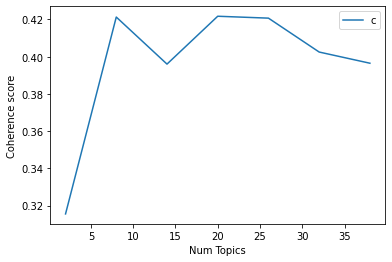

Num topics= 2  has coherence value of 0.3156
Num topics= 8  has coherence value of 0.4213
Num topics= 14  has coherence value of 0.396
Num topics= 20  has coherence value of 0.4217
Num topics= 26  has coherence value of 0.4207
Num topics= 32  has coherence value of 0.4025
Num topics= 38  has coherence value of 0.3965


In [23]:
# Graph iterations
limit=40; start=2; step=6
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print('Num topics=', m, ' has coherence value of', round(cv, 4))

In [24]:
# Set n to optimal model
n = 4  # fifth model has highest coherence value
# We coud reurn in rang 8 to 20 in 1 point increments to smooth and ensure global optimum
optimal_model= model_list[n]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

# Reduce to top 3 words per topic

[(13,
  '0.057*"say" + 0.022*"offer" + 0.017*"licence" + 0.015*"bonus" + '
  '0.015*"wheat" + 0.012*"export" + 0.011*"tonne" + 0.011*"today" + '
  '0.011*"take" + 0.011*"market"'),
 (2,
  '0.039*"say" + 0.034*"soybean" + 0.031*"acre" + 0.027*"program" + '
  '0.017*"regular" + 0.017*"acreage" + 0.017*"set" + 0.014*"crop" + '
  '0.014*"initial" + 0.013*"aluminium"'),
 (12,
  '0.076*"franc" + 0.024*"french" + 0.022*"say" + 0.013*"cable" + '
  '0.013*"official" + 0.012*"new" + 0.011*"employer" + 0.010*"issue" + '
  '0.010*"redundancy" + 0.009*"sector"'),
 (1,
  '0.064*"oil" + 0.061*"price" + 0.048*"corn" + 0.046*"say" + 0.041*"raise" + '
  '0.028*"crude" + 0.017*"today" + 0.017*"qtly" + 0.015*"tender" + '
  '0.015*"barrel"'),
 (0,
  '0.059*"say" + 0.023*"rate" + 0.015*"growth" + 0.012*"economy" + '
  '0.011*"would" + 0.011*"economic" + 0.010*"dollar" + 0.010*"year" + '
  '0.009*"first" + 0.008*"exchange"'),
 (25,
  '0.060*"price" + 0.040*"say" + 0.029*"year" + 0.024*"production" + '
  '0.0

In [44]:
# include visualization tool

### Topic Prevalence

In [25]:
# JO: troubleshoot TypeError:  https://cs50.stackexchange.com/questions/30671/typeerror-not-supported-between-instances-of-int-and-tuple


# MI: the error comes the sorting function which cant do a comparison because of the intracte structure of the rows.
# I printed out the content below to look at the structure

# Find dominant topic by sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Loop through articles to get each article's main topic
    for i, article in enumerate(ldamodel[corpus]):
        for article in enumerate(article):  # JO: removed the sort operation here - think we'll need to figure out another way to resort the article value, but leaving for now
            if article[0] == 0:
                
                print(article)
                
                wp = optimal_model.show_topic(article[1][0][0])
                topic_keywords = ', '.join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(article[1][0][0]), 
                                                                  round(article[1][0][1],4), 
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    return(sent_topics_df)


In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']

# Show
df_dominant_topic.head(10)

(0, [(6, 0.71540296), (8, 0.23547642), (9, 0.03629349)])
(0, [(3, 0.11698307), (8, 0.18543296), (13, 0.39937773), (16, 0.1889327), (25, 0.09046502)])
(0, [(2, 0.01523876), (5, 0.19888759), (8, 0.15494196), (23, 0.44755426), (25, 0.17278123)])
(0, [(0, 0.17895305), (6, 0.10853375), (13, 0.07065551), (23, 0.5200894), (25, 0.11017169)])
(0, [(4, 0.03372108), (8, 0.3998467), (14, 0.038081303), (25, 0.517638)])
(0, [(6, 0.21608989), (11, 0.27205232), (16, 0.47817606), (25, 0.024554672)])
(0, [(6, 0.03830936), (8, 0.26903263), (11, 0.6424297), (21, 0.0420454)])
(0, [(2, 0.09436086), (13, 0.6361757), (19, 0.2229005)])
(0, [(8, 0.3761106), (14, 0.4429151), (22, 0.15827914)])
(0, [(0, 0.039218135), (3, 0.16895342), (5, 0.10551747), (6, 0.21486804), (8, 0.037906125), (11, 0.13364936), (16, 0.01017687), (17, 0.12776501), (22, 0.1593439)])
(0, [(6, 0.5215044), (7, 0.15145004), (8, 0.105822064), (16, 0.10395872), (24, 0.0937144)])
(0, [(3, 0.07253302), (4, 0.5850639), (8, 0.20951237), (17, 0.106986

(0, [(3, 0.48372307), (19, 0.46513095)])
(0, [(3, 0.34032303), (5, 0.30034646), (9, 0.21613722), (10, 0.07378505), (11, 0.046398915)])
(0, [(0, 0.0128205465), (1, 0.0128205465), (2, 0.0128205465), (3, 0.0128205465), (4, 0.0128205465), (5, 0.0128205465), (6, 0.0128205465), (7, 0.0128205465), (8, 0.0128205465), (9, 0.67948633), (10, 0.0128205465), (11, 0.0128205465), (12, 0.0128205465), (13, 0.0128205465), (14, 0.0128205465), (15, 0.0128205465), (16, 0.0128205465), (17, 0.0128205465), (18, 0.0128205465), (19, 0.0128205465), (20, 0.0128205465), (21, 0.0128205465), (22, 0.0128205465), (23, 0.0128205465), (24, 0.0128205465), (25, 0.0128205465)])
(0, [(2, 0.23686688), (20, 0.6792142)])
(0, [(20, 0.75961494)])
(0, [(8, 0.40699607), (14, 0.5146185), (21, 0.06832735)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7, 0.03846154), (8, 0.03846154), (9, 0.03846154), (10, 0.03846154), (11, 0.03846154), (12, 0.03846154), 

(0, [(0, 0.048108924), (3, 0.033924162), (6, 0.886438), (16, 0.026372567)])
(0, [(3, 0.4416213), (19, 0.05599443), (25, 0.4871513)])
(0, [(12, 0.14940846), (20, 0.7186936)])
(0, [(3, 0.3554639), (5, 0.060130216), (15, 0.18035215), (19, 0.11326767), (25, 0.26702672)])
(0, [(0, 0.0761126), (9, 0.17496423), (18, 0.15757248), (22, 0.57408273)])
(0, [(6, 0.9562852), (14, 0.02633071)])
(0, [(9, 0.2828434), (20, 0.6017707)])
(0, [(0, 0.01282082), (1, 0.01282082), (2, 0.01282082), (3, 0.01282082), (4, 0.01282082), (5, 0.01282082), (6, 0.01282082), (7, 0.31733996), (8, 0.01282082), (9, 0.01282082), (10, 0.01282082), (11, 0.01282082), (12, 0.01282082), (13, 0.01282082), (14, 0.01282082), (15, 0.01282082), (16, 0.01282082), (17, 0.01282082), (18, 0.37496036), (19, 0.01282082), (20, 0.01282082), (21, 0.01282082), (22, 0.01282082), (23, 0.01282082), (24, 0.01282082), (25, 0.01282082)])
(0, [(11, 0.36099976), (14, 0.06325256), (15, 0.23494884), (17, 0.32512638)])
(0, [(0, 0.01923081), (1, 0.01923081

(0, [(8, 0.12240985), (23, 0.36815524), (25, 0.49242043)])
(0, [(0, 0.45731625), (6, 0.24109076), (8, 0.088123895), (9, 0.029527381), (11, 0.17164807), (16, 0.010167082)])
(0, [(18, 0.93131846)])
(0, [(17, 0.19626074), (18, 0.67186755)])
(0, [(2, 0.67416155), (8, 0.19277938), (21, 0.07487183), (25, 0.04643036)])
(0, [(17, 0.15738158), (18, 0.2011167), (20, 0.56777245)])
(0, [(7, 0.101152495), (8, 0.22155635), (11, 0.1073673), (22, 0.56112325)])
(0, [(0, 0.53075504), (4, 0.12919891), (6, 0.11869784), (11, 0.07000697), (15, 0.032136187), (17, 0.09586839), (23, 0.020588834)])
(0, [(17, 0.06715832), (23, 0.8986365)])
(0, [(5, 0.59167576), (9, 0.1616282), (19, 0.21509589)])
(0, [(6, 0.60973036), (8, 0.24427956), (13, 0.13352345)])
(0, [(2, 0.12801175), (8, 0.70946336), (9, 0.10410957), (15, 0.039199557)])
(0, [(0, 0.04313879), (3, 0.22402678), (6, 0.32378846), (8, 0.106034406), (11, 0.08128929), (12, 0.028983995), (16, 0.155222), (17, 0.028544948)])
(0, [(0, 0.4599274), (10, 0.010032341), (

(0, [(8, 0.5061124), (11, 0.15020713), (13, 0.062225223), (14, 0.052536234), (22, 0.051060345), (25, 0.1584496)])
(0, [(9, 0.70924985), (14, 0.07011181), (15, 0.1165316), (23, 0.061780807)])
(0, [(18, 0.21557102), (20, 0.6690438)])
(0, [(17, 0.9519195)])
(0, [(3, 0.7399989), (19, 0.1846267)])
(0, [(0, 0.42928103), (2, 0.031658992), (4, 0.15174136), (8, 0.28487933), (15, 0.07865293)])
(0, [(1, 0.24689598), (6, 0.2076331), (9, 0.073755816), (25, 0.4196648)])
(0, [(3, 0.378258), (7, 0.34060213), (10, 0.011019061), (11, 0.02011753), (19, 0.13135104), (23, 0.10795065)])
(0, [(18, 0.80769217)])
(0, [(0, 0.13922235), (6, 0.039642155), (11, 0.02568281), (13, 0.15479569), (14, 0.33281296), (16, 0.1111468), (25, 0.1910051)])
(0, [(2, 0.8988615), (20, 0.064206146)])
(0, [(1, 0.10522373), (3, 0.6570054), (7, 0.09867488), (20, 0.1286633)])
(0, [(0, 0.012820558), (1, 0.012820558), (2, 0.012820558), (3, 0.012820558), (4, 0.012820558), (5, 0.012820558), (6, 0.012820558), (7, 0.012820558), (8, 0.012820

(0, [(0, 0.33813113), (1, 0.09969156), (6, 0.5361301)])
(0, [(0, 0.35114962), (1, 0.012838104), (2, 0.012838104), (3, 0.012838104), (4, 0.012838104), (5, 0.012838104), (6, 0.012838104), (7, 0.012838104), (8, 0.012838104), (9, 0.012838104), (10, 0.012838104), (11, 0.012838104), (12, 0.012838104), (13, 0.012838104), (14, 0.012838104), (15, 0.012838104), (16, 0.012838104), (17, 0.012838104), (18, 0.012838104), (19, 0.3407359), (20, 0.012838104), (21, 0.012838104), (22, 0.012838104), (23, 0.012838104), (24, 0.012838104), (25, 0.012838104)])
(0, [(0, 0.028248398), (14, 0.18804821), (16, 0.42366084), (22, 0.28897092), (24, 0.051703572)])
(0, [(3, 0.96668243)])
(0, [(20, 0.83974123)])
(0, [(5, 0.045406245), (9, 0.066278055), (18, 0.088223524), (22, 0.78707504)])
(0, [(11, 0.02958799), (18, 0.7823778), (20, 0.12537216), (23, 0.03692403)])
(0, [(19, 0.17772458), (20, 0.6684259)])
(0, [(20, 0.8397432)])
(0, [(14, 0.13191155), (20, 0.7526562)])
(0, [(1, 0.050494913), (5, 0.50969374), (14, 0.38763

(0, [(13, 0.9679473)])
(0, [(25, 0.9541964)])
(0, [(2, 0.3809988), (6, 0.12514693), (8, 0.09451161), (14, 0.34099212), (24, 0.042527657)])
(0, [(2, 0.34638247), (20, 0.4997699)])
(0, [(5, 0.11279537), (14, 0.8753518)])
(0, [(6, 0.14409629), (9, 0.3299709), (20, 0.39843127)])
(0, [(1, 0.18835819), (20, 0.65779305)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7, 0.03846154), (8, 0.03846154), (9, 0.03846154), (10, 0.03846154), (11, 0.03846154), (12, 0.03846154), (13, 0.03846154), (14, 0.03846154), (15, 0.03846154), (16, 0.03846154), (17, 0.03846154), (18, 0.03846154), (19, 0.03846154), (20, 0.03846154), (21, 0.03846154), (22, 0.03846154), (23, 0.03846154), (24, 0.03846154), (25, 0.03846154)])
(0, [(1, 0.03776583), (3, 0.10621159), (8, 0.6702486), (15, 0.02111253), (23, 0.1586727)])
(0, [(11, 0.893121)])
(0, [(9, 0.7596014)])
(0, [(5, 0.25730032), (14, 0.04396749), (16, 0.29635486), (23, 0.37642416)])
(0, [(3

(0, [(8, 0.3022088), (13, 0.21241389), (23, 0.32829413), (25, 0.13480924)])
(0, [(4, 0.10630726), (11, 0.1770079), (13, 0.44511086), (17, 0.24012011)])
(0, [(6, 0.031328116), (8, 0.69702625), (13, 0.09660761), (14, 0.16894011)])
(0, [(3, 0.15265195), (7, 0.6471264), (23, 0.16604021)])
(0, [(3, 0.08655911), (6, 0.6601735), (10, 0.05658649), (15, 0.016034067), (16, 0.17337124)])
(0, [(1, 0.075584985), (8, 0.04115158), (13, 0.115560934), (14, 0.19750787), (25, 0.5600001)])
(0, [(0, 0.753812), (15, 0.08910594), (23, 0.0563787), (24, 0.07896536)])
(0, [(1, 0.104146205), (3, 0.18682638), (7, 0.11521428), (8, 0.06513176), (9, 0.043699875), (14, 0.15171134), (15, 0.15944695), (19, 0.15455806)])
(0, [(12, 0.18925865), (17, 0.7554725), (20, 0.030821972)])
(0, [(10, 0.24476096), (11, 0.12199247), (18, 0.054489017), (19, 0.34858552), (23, 0.20235175)])
(0, [(5, 0.25512603), (11, 0.17437924), (13, 0.04484595), (14, 0.24525292), (17, 0.18732029), (25, 0.07043976)])
(0, [(0, 0.29869843), (6, 0.060340

(0, [(0, 0.09598269), (2, 0.039979655), (22, 0.15792187), (23, 0.6838301)])
(0, [(4, 0.097235896), (18, 0.75159895), (19, 0.07074316)])
(0, [(5, 0.055416994), (9, 0.3335423), (22, 0.5256633), (25, 0.06310268)])
(0, [(1, 0.9599323)])
(0, [(17, 0.31208116), (18, 0.21585768), (19, 0.16397005), (22, 0.25520137)])
(0, [(13, 0.8825667), (21, 0.08446537)])
(0, [(18, 0.807683)])
(0, [(14, 0.772488), (15, 0.14964229), (24, 0.05258756)])
(0, [(18, 0.8397423)])
(0, [(3, 0.53068227), (8, 0.21584247), (14, 0.1885839), (23, 0.0399913)])
(0, [(17, 0.11885973), (18, 0.4197124), (20, 0.38770708)])
(0, [(2, 0.04151583), (14, 0.06264248), (24, 0.6590267), (25, 0.20295724)])
(0, [(15, 0.9708601)])
(0, [(0, 0.10577984), (2, 0.118248604), (3, 0.25687605), (8, 0.039445147), (9, 0.17691655), (10, 0.05984336), (13, 0.05763321), (19, 0.1651857), (24, 0.01407412)])
(0, [(0, 0.19667998), (8, 0.064120166), (9, 0.07222817), (22, 0.49582696), (23, 0.16332798)])
(0, [(18, 0.9198714)])
(0, [(0, 0.1775012), (5, 0.27940

(0, [(7, 0.20360929), (19, 0.62612873), (23, 0.1112829)])
(0, [(18, 0.83974206)])
(0, [(3, 0.54055613), (9, 0.18517832), (19, 0.23887737)])
(0, [(5, 0.220941), (7, 0.4376702), (15, 0.055955473), (19, 0.25304538)])
(0, [(0, 0.019230792), (1, 0.019230792), (2, 0.019230792), (3, 0.019230792), (4, 0.019230792), (5, 0.019230792), (6, 0.019230792), (7, 0.019230792), (8, 0.019230792), (9, 0.019230792), (10, 0.019230792), (11, 0.019230792), (12, 0.019230792), (13, 0.019230792), (14, 0.019230792), (15, 0.019230792), (16, 0.019230792), (17, 0.019230792), (18, 0.5192302), (19, 0.019230792), (20, 0.019230792), (21, 0.019230792), (22, 0.019230792), (23, 0.019230792), (24, 0.019230792), (25, 0.019230792)])
(0, [(5, 0.56014246), (19, 0.37831277)])
(0, [(19, 0.6138651), (22, 0.328348)])
(0, [(9, 0.32773206), (24, 0.5696964)])
(0, [(9, 0.45006308), (24, 0.45762268)])
(0, [(9, 0.46717766), (24, 0.44889948)])
(0, [(9, 0.45024243), (24, 0.45744336)])
(0, [(9, 0.430875), (24, 0.466555)])
(0, [(9, 0.3277944

(0, [(3, 0.29445258), (5, 0.36178938), (6, 0.15959764), (16, 0.10888158), (18, 0.045390885)])
(0, [(4, 0.08494519), (5, 0.32618728), (19, 0.5575706)])
(0, [(8, 0.9932665)])
(0, [(23, 0.963016)])
(0, [(7, 0.07432959), (12, 0.03892284), (16, 0.72353905), (19, 0.14518791)])
(0, [(7, 0.5271395), (15, 0.15768889), (19, 0.25986788)])
(0, [(1, 0.2332408), (20, 0.66419303)])
(0, [(18, 0.8798039)])
(0, [(9, 0.8970508), (18, 0.04141011)])
(0, [(3, 0.96610755), (9, 0.022507083)])
(0, [(8, 0.99217534)])
(0, [(17, 0.26599312), (18, 0.580156)])
(0, [(14, 0.257615), (19, 0.5416032), (22, 0.112288326)])
(0, [(17, 0.26631418), (18, 0.5798353)])
(0, [(18, 0.8798076)])
(0, [(7, 0.4132895), (13, 0.077429615), (19, 0.22488475), (25, 0.23736647)])
(0, [(17, 0.16589321), (18, 0.55062073), (19, 0.1851917)])
(0, [(7, 0.14834352), (18, 0.5070964), (20, 0.25608853)])
(0, [(7, 0.4897662), (12, 0.10373136), (18, 0.33277744)])
(0, [(7, 0.7596115)])
(0, [(19, 0.9581912)])
(0, [(3, 0.8017885), (16, 0.022881096), (18,

(0, [(7, 0.17912826), (17, 0.15190007), (18, 0.5425866)])
(0, [(7, 0.3174966), (15, 0.20938739), (23, 0.4362045)])
(0, [(18, 0.93131816)])
(0, [(9, 0.19211137), (20, 0.6540416)])
(0, [(9, 0.36526516), (18, 0.4039647)])
(0, [(18, 0.86263597)])
(0, [(0, 0.019230789), (1, 0.019230789), (2, 0.019230789), (3, 0.019230789), (4, 0.019230789), (5, 0.019230789), (6, 0.019230789), (7, 0.019230789), (8, 0.019230789), (9, 0.019230789), (10, 0.019230789), (11, 0.019230789), (12, 0.019230789), (13, 0.019230789), (14, 0.019230789), (15, 0.019230789), (16, 0.019230789), (17, 0.019230789), (18, 0.51923025), (19, 0.019230789), (20, 0.019230789), (21, 0.019230789), (22, 0.019230789), (23, 0.019230789), (24, 0.019230789), (25, 0.019230789)])
(0, [(9, 0.25639582), (18, 0.7148341)])
(0, [(20, 0.8397431)])
(0, [(14, 0.15131058), (18, 0.77175385)])
(0, [(9, 0.37350115), (22, 0.5909911)])
(0, [(18, 0.91258687)])
(0, [(7, 0.15947981), (9, 0.3253496), (22, 0.48663238)])
(0, [(1, 0.01585079), (3, 0.36381283), (5,

(0, [(6, 0.8421999), (23, 0.13969612)])
(0, [(3, 0.8771812), (8, 0.024353405), (19, 0.05931157), (24, 0.025489327)])
(0, [(5, 0.6405884), (8, 0.15927653), (14, 0.1614085), (23, 0.02812882)])
(0, [(19, 0.70226324), (23, 0.22079434)])
(0, [(3, 0.1673738), (8, 0.12908946), (11, 0.6533975), (22, 0.041927297)])
(0, [(2, 0.070367925), (4, 0.02434713), (8, 0.025474822), (14, 0.29506525), (16, 0.55958664), (18, 0.0148786865)])
(0, [(4, 0.94939196)])
(0, [(5, 0.14792618), (11, 0.5287741), (19, 0.30226392)])
(0, [(0, 0.012820595), (1, 0.012820595), (2, 0.012820595), (3, 0.012820595), (4, 0.012820595), (5, 0.012820595), (6, 0.012820595), (7, 0.012820595), (8, 0.012820595), (9, 0.012820595), (10, 0.012820595), (11, 0.012820595), (12, 0.012820595), (13, 0.012820595), (14, 0.012820595), (15, 0.012820595), (16, 0.012820595), (17, 0.012820595), (18, 0.012820595), (19, 0.6794851), (20, 0.012820595), (21, 0.012820595), (22, 0.012820595), (23, 0.012820595), (24, 0.012820595), (25, 0.012820595)])
(0, [(3,

(0, [(7, 0.4629474), (17, 0.10539447), (18, 0.0641371), (19, 0.32697952)])
(0, [(0, 0.6468688), (6, 0.29542193)])
(0, [(7, 0.09748649), (19, 0.5591862), (22, 0.19858433), (25, 0.110744596)])
(0, [(0, 0.419645), (19, 0.5322779)])
(0, [(0, 0.9746612)])
(0, [(5, 0.6170374), (7, 0.32761928)])
(0, [(0, 0.6114557), (3, 0.04338847), (6, 0.24540295), (8, 0.023129497), (11, 0.043815874), (21, 0.012185399)])
(0, [(0, 0.012820527), (1, 0.012820527), (2, 0.012820527), (3, 0.012820527), (4, 0.012820527), (5, 0.012820527), (6, 0.012820527), (7, 0.012820527), (8, 0.012820527), (9, 0.012820527), (10, 0.012820527), (11, 0.012820527), (12, 0.012820527), (13, 0.012820527), (14, 0.012820527), (15, 0.012820527), (16, 0.012820527), (17, 0.012820527), (18, 0.6794868), (19, 0.012820527), (20, 0.012820527), (21, 0.012820527), (22, 0.012820527), (23, 0.012820527), (24, 0.012820527), (25, 0.012820527)])
(0, [(3, 0.43321404), (19, 0.5154995)])
(0, [(18, 0.8626372)])
(0, [(5, 0.2455376), (8, 0.19363748), (9, 0.060

(0, [(18, 0.9434388)])
(0, [(3, 0.22605158), (5, 0.17815146), (7, 0.23816898), (19, 0.33272693)])
(0, [(0, 0.2997691), (6, 0.05490512), (8, 0.21080607), (11, 0.07898562), (15, 0.027088733), (17, 0.07247238), (23, 0.25355345)])
(0, [(18, 0.8076899)])
(0, [(3, 0.24185267), (5, 0.0741873), (6, 0.10741208), (17, 0.08929514), (19, 0.3632704), (25, 0.098310634)])
(0, [(18, 0.89316225)])
(0, [(3, 0.9548251)])
(0, [(8, 0.9555605), (9, 0.026643135)])
(0, [(0, 0.5299346), (3, 0.010837814), (6, 0.17880212), (8, 0.056929275), (11, 0.1722187), (17, 0.034704845)])
(0, [(9, 0.09072047), (13, 0.08583853), (19, 0.4227513), (22, 0.33011782)])
(0, [(3, 0.094364285), (7, 0.09785171), (15, 0.18197276), (19, 0.23637253), (22, 0.37260792)])
(0, [(3, 0.25534895), (6, 0.019452568), (7, 0.044882532), (11, 0.39776066), (13, 0.24268986), (15, 0.0152277155), (22, 0.021131018)])
(0, [(18, 0.9125858)])
(0, [(3, 0.47454783), (5, 0.3197891), (19, 0.088848725), (22, 0.102223255)])
(0, [(0, 0.34792542), (6, 0.28478467),

(0, [(18, 0.7960128), (20, 0.11167912)])
(0, [(18, 0.7596105)])
(0, [(1, 0.13611619), (8, 0.35679707), (9, 0.2841104), (20, 0.14601626)])
(0, [(3, 0.46197343), (6, 0.04794231), (7, 0.45956776)])
(0, [(0, 0.04815377), (8, 0.13009806), (10, 0.033855986), (11, 0.17176984), (14, 0.12657666), (22, 0.36608475), (23, 0.03856678), (25, 0.08148054)])
(0, [(15, 0.45923692), (19, 0.11873068), (22, 0.07390527), (23, 0.31678388)])
(0, [(8, 0.55398464), (16, 0.26144174), (21, 0.15775444)])
(0, [(3, 0.304769), (5, 0.23072775), (6, 0.034443498), (8, 0.28202638), (17, 0.10996213), (22, 0.025987482)])
(0, [(18, 0.9434377)])
(0, [(0, 0.16303238), (6, 0.77161515), (12, 0.016452922), (16, 0.039370563)])
(0, [(6, 0.9436076), (11, 0.044133566)])
(0, [(3, 0.11142917), (8, 0.6417226), (9, 0.04772043), (16, 0.1459978), (19, 0.015553367), (21, 0.028536387)])
(0, [(3, 0.8303953), (24, 0.14476077)])
(0, [(5, 0.5696359), (19, 0.32778022)])
(0, [(3, 0.0270509), (8, 0.12330088), (14, 0.6195348), (16, 0.15786858), (22

(0, [(3, 0.23785712), (11, 0.43718407), (19, 0.13008258), (22, 0.100129485), (23, 0.06588751)])
(0, [(3, 0.03774713), (5, 0.37762415), (7, 0.13831037), (8, 0.097258024), (9, 0.05360642), (11, 0.19314633), (22, 0.09649131)])
(0, [(1, 0.501139), (3, 0.36617604), (16, 0.10583834)])
(0, [(1, 0.8131231), (9, 0.10993049)])
(0, [(1, 0.9358969)])
(0, [(18, 0.56535447), (20, 0.25002867)])
(0, [(0, 0.03341357), (16, 0.915374), (21, 0.040605735)])
(0, [(1, 0.7651964), (9, 0.17324997)])
(0, [(18, 0.8931607)])
(0, [(1, 0.7640176), (9, 0.1436493)])
(0, [(1, 0.9125866)])
(0, [(1, 0.76404387), (9, 0.14362298)])
(0, [(1, 0.63419324), (18, 0.2734598)])
(0, [(18, 0.91987133)])
(0, [(18, 0.90384597)])
(0, [(7, 0.17017116), (18, 0.737517)])
(0, [(18, 0.94435996), (20, 0.023809498)])
(0, [(8, 0.07334685), (18, 0.8722948)])
(0, [(4, 0.17454842), (8, 0.095631026), (10, 0.028958963), (15, 0.5629459), (16, 0.11718599)])
(0, [(1, 0.64326847), (10, 0.06720694), (19, 0.10124196), (20, 0.14596742)])
(0, [(3, 0.1279

(0, [(0, 0.32831955), (8, 0.029284172), (23, 0.63420606)])
(0, [(0, 0.36235428), (6, 0.03354175), (16, 0.08846582), (23, 0.50681645)])
(0, [(0, 0.29196376), (6, 0.2620619), (12, 0.05064288), (16, 0.22505713), (23, 0.16135147)])
(0, [(0, 0.50671333), (6, 0.05877647), (23, 0.42969057)])
(0, [(4, 0.14525335), (18, 0.72733325), (20, 0.06843799)])
(0, [(0, 0.7470978), (6, 0.0654964), (8, 0.091627054), (16, 0.06089524), (23, 0.031429272)])
(0, [(0, 0.65514475), (23, 0.22940932)])
(0, [(0, 0.2654681), (8, 0.21341525), (23, 0.51138735)])
(0, [(3, 0.34382358), (11, 0.070266664), (22, 0.5804878)])
(0, [(0, 0.14552577), (9, 0.509981), (18, 0.31289667)])
(0, [(0, 0.2137063), (8, 0.10008579), (16, 0.04841136), (23, 0.60477936), (25, 0.025246738)])
(0, [(17, 0.8931618)])
(0, [(4, 0.17171809), (6, 0.64725155), (7, 0.1129725)])
(0, [(3, 0.07435665), (17, 0.89487165)])
(0, [(4, 0.41452464), (6, 0.55126095)])
(0, [(0, 0.77919775), (4, 0.09521004), (8, 0.05250512), (23, 0.038286075), (25, 0.031541057)])


(0, [(11, 0.5968514), (23, 0.31031504)])
(0, [(18, 0.91676784), (20, 0.04309769)])
(0, [(15, 0.5191554), (20, 0.14561549), (24, 0.2548075)])
(0, [(3, 0.20874871), (5, 0.44865423), (20, 0.07619804), (23, 0.20595264)])
(0, [(7, 0.4213701), (11, 0.2378058), (19, 0.3068642)])
(0, [(3, 0.51333976), (8, 0.05018185), (11, 0.18056405), (22, 0.2346991)])
(0, [(18, 0.93990284)])
(0, [(4, 0.011310441), (8, 0.51517063), (11, 0.21016413), (16, 0.257627)])
(0, [(3, 0.3478421), (7, 0.49880376), (19, 0.1322883)])
(0, [(18, 0.90384585)])
(0, [(0, 0.07187001), (2, 0.89881617)])
(0, [(6, 0.045572195), (8, 0.62661356), (11, 0.25295752), (17, 0.061425403)])
(0, [(18, 0.8807268), (20, 0.061580557)])
(0, [(18, 0.95192236)])
(0, [(3, 0.09697184), (6, 0.8348788), (8, 0.063087806)])
(0, [(0, 0.046704132), (3, 0.14924406), (7, 0.11450314), (11, 0.3318393), (13, 0.29254758), (15, 0.036624167), (22, 0.01839921)])
(0, [(5, 0.38225567), (25, 0.57796144)])
(0, [(3, 0.6525853), (12, 0.045291297), (17, 0.09213243), (22

(0, [(5, 0.04135381), (18, 0.8806018), (20, 0.046444226)])
(0, [(3, 0.40886864), (19, 0.30658296), (21, 0.0933742), (23, 0.1559046)])
(0, [(6, 0.41595766), (9, 0.5061482)])
(0, [(18, 0.7782232), (20, 0.119212024)])
(0, [(3, 0.85402036), (5, 0.118002914)])
(0, [(3, 0.08961735), (18, 0.2644737), (23, 0.5778441)])
(0, [(18, 0.95420986)])
(0, [(0, 0.37541902), (20, 0.11719836), (23, 0.48409396)])
(0, [(3, 0.8935642), (25, 0.074602306)])
(0, [(18, 0.80769134)])
(0, [(0, 0.0128205735), (1, 0.0128205735), (2, 0.0128205735), (3, 0.0128205735), (4, 0.0128205735), (5, 0.0128205735), (6, 0.0128205735), (7, 0.0128205735), (8, 0.0128205735), (9, 0.0128205735), (10, 0.0128205735), (11, 0.0128205735), (12, 0.0128205735), (13, 0.0128205735), (14, 0.0128205735), (15, 0.0128205735), (16, 0.0128205735), (17, 0.0128205735), (18, 0.33376345), (19, 0.0128205735), (20, 0.3585428), (21, 0.0128205735), (22, 0.0128205735), (23, 0.0128205735), (24, 0.0128205735), (25, 0.0128205735)])
(0, [(3, 0.095176026), (6, 0

(0, [(3, 0.02972236), (5, 0.38434982), (7, 0.07068489), (9, 0.16675442), (14, 0.1593755), (19, 0.10856003), (22, 0.017735533), (23, 0.0518523)])
(0, [(15, 0.12023665), (18, 0.71917886), (22, 0.10159483)])
(0, [(10, 0.07599643), (19, 0.79788864), (25, 0.07404484)])
(0, [(3, 0.9038152)])
(0, [(3, 0.18959406), (5, 0.12553103), (6, 0.042748068), (19, 0.34366596), (22, 0.27595612)])
(0, [(3, 0.68692875), (5, 0.15775725), (7, 0.036209624), (11, 0.05713665), (14, 0.048933245)])
(0, [(1, 0.025143325), (2, 0.031050041), (6, 0.39159012), (8, 0.36687955), (16, 0.08655605), (23, 0.08942629)])
(0, [(2, 0.15073545), (3, 0.32726374), (4, 0.07287557), (6, 0.036821183), (8, 0.06886823), (22, 0.33497104)])
(0, [(3, 0.4163225), (9, 0.12669198), (11, 0.33161953), (19, 0.1127341)])
(0, [(18, 0.93131834)])
(0, [(7, 0.19286904), (11, 0.21803518), (15, 0.12250931), (19, 0.42809463)])
(0, [(10, 0.054548327), (19, 0.9258102)])
(0, [(7, 0.9562915)])
(0, [(1, 0.010305639), (3, 0.07517486), (6, 0.40425378), (8, 0.

(0, [(9, 0.5274368), (12, 0.05110098), (18, 0.40263912)])
(0, [(9, 0.064625025), (18, 0.8911933), (24, 0.020897204)])
(0, [(9, 0.2558995), (18, 0.68980116)])
(0, [(0, 0.01923079), (1, 0.01923079), (2, 0.01923079), (3, 0.01923079), (4, 0.01923079), (5, 0.01923079), (6, 0.01923079), (7, 0.01923079), (8, 0.01923079), (9, 0.01923079), (10, 0.01923079), (11, 0.01923079), (12, 0.01923079), (13, 0.01923079), (14, 0.01923079), (15, 0.01923079), (16, 0.01923079), (17, 0.01923079), (18, 0.5192302), (19, 0.01923079), (20, 0.01923079), (21, 0.01923079), (22, 0.01923079), (23, 0.01923079), (24, 0.01923079), (25, 0.01923079)])
(0, [(1, 0.015893364), (3, 0.054797396), (6, 0.45660102), (8, 0.1337031), (11, 0.16720283), (21, 0.16245273)])
(0, [(2, 0.09192518), (4, 0.06574697), (7, 0.16267076), (9, 0.3525846), (18, 0.29189336)])
(0, [(9, 0.51320016), (18, 0.33295232)])
(0, [(9, 0.5962), (18, 0.3327928)])
(0, [(3, 0.86263007)])
(0, [(18, 0.807688)])
(0, [(9, 0.8076916)])
(0, [(9, 0.39958817), (20, 0.5081

(0, [(0, 0.019230813), (1, 0.019230813), (2, 0.019230813), (3, 0.019230813), (4, 0.019230813), (5, 0.019230813), (6, 0.019230813), (7, 0.019230813), (8, 0.019230813), (9, 0.019230813), (10, 0.019230813), (11, 0.019230813), (12, 0.019230813), (13, 0.019230813), (14, 0.019230813), (15, 0.019230813), (16, 0.019230813), (17, 0.019230813), (18, 0.26017377), (19, 0.019230813), (20, 0.27828676), (21, 0.019230813), (22, 0.019230813), (23, 0.019230813), (24, 0.019230813), (25, 0.019230813)])
(0, [(18, 0.28180102), (20, 0.3995929), (21, 0.24488497)])
(0, [(7, 0.17044197), (20, 0.7141678)])
(0, [(12, 0.18246298), (18, 0.3732741), (19, 0.29681998)])
(0, [(18, 0.83974063)])
(0, [(18, 0.90384585)])
(0, [(18, 0.8076917)])
(0, [(0, 0.83123785), (6, 0.11105782)])
(0, [(7, 0.3143027), (17, 0.10905814), (18, 0.52134764)])
(0, [(1, 0.024489108), (3, 0.15936363), (7, 0.61285055), (11, 0.116259724), (20, 0.07087895)])
(0, [(18, 0.9434388)])
(0, [(18, 0.8931613)])
(0, [(2, 0.051568348), (3, 0.1337439), (4, 0

(0, [(0, 0.012820524), (1, 0.012820524), (2, 0.012820524), (3, 0.012820524), (4, 0.012820524), (5, 0.012820524), (6, 0.012820524), (7, 0.012820524), (8, 0.012820524), (9, 0.012820524), (10, 0.012820524), (11, 0.012820524), (12, 0.012820524), (13, 0.012820524), (14, 0.012820524), (15, 0.012820524), (16, 0.012820524), (17, 0.012820524), (18, 0.6794869), (19, 0.012820524), (20, 0.012820524), (21, 0.012820524), (22, 0.012820524), (23, 0.012820524), (24, 0.012820524), (25, 0.012820524)])
(0, [(18, 0.91987056)])
(0, [(0, 0.01923079), (1, 0.01923079), (2, 0.01923079), (3, 0.01923079), (4, 0.01923079), (5, 0.01923079), (6, 0.01923079), (7, 0.01923079), (8, 0.01923079), (9, 0.01923079), (10, 0.01923079), (11, 0.01923079), (12, 0.01923079), (13, 0.01923079), (14, 0.01923079), (15, 0.01923079), (16, 0.01923079), (17, 0.01923079), (18, 0.5192302), (19, 0.01923079), (20, 0.01923079), (21, 0.01923079), (22, 0.01923079), (23, 0.01923079), (24, 0.01923079), (25, 0.01923079)])
(0, [(8, 0.20646816), (18

(0, [(0, 0.019231057), (1, 0.019231057), (2, 0.019231057), (3, 0.019231057), (4, 0.019231057), (5, 0.019231057), (6, 0.019231057), (7, 0.019231057), (8, 0.019231057), (9, 0.019231057), (10, 0.019231057), (11, 0.019231057), (12, 0.019231057), (13, 0.019231057), (14, 0.019231057), (15, 0.019231057), (16, 0.019231057), (17, 0.019231057), (18, 0.019231057), (19, 0.019231057), (20, 0.019231057), (21, 0.019231057), (22, 0.5192236), (23, 0.019231057), (24, 0.019231057), (25, 0.019231057)])
(0, [(6, 0.81870353), (14, 0.015675174), (16, 0.018077485), (25, 0.1395986)])
(0, [(2, 0.015902584), (5, 0.22879852), (8, 0.41869003), (10, 0.03169573), (14, 0.29428065)])
(0, [(5, 0.11460525), (18, 0.8084674)])
(0, [(3, 0.51466787), (4, 0.12958443), (14, 0.040851507), (17, 0.088802956), (22, 0.19791527)])
(0, [(18, 0.87980604)])
(0, [(9, 0.28728572), (12, 0.07515834), (18, 0.5785773)])
(0, [(0, 0.7632273), (3, 0.13154249), (4, 0.08942377)])
(0, [(3, 0.7362698), (7, 0.14423765), (23, 0.08546566)])
(0, [(2, 

(0, [(18, 0.8626353)])
(0, [(9, 0.4419498), (18, 0.48704246)])
(0, [(18, 0.97329)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7, 0.03846154), (8, 0.03846154), (9, 0.03846154), (10, 0.03846154), (11, 0.03846154), (12, 0.03846154), (13, 0.03846154), (14, 0.03846154), (15, 0.03846154), (16, 0.03846154), (17, 0.03846154), (18, 0.03846154), (19, 0.03846154), (20, 0.03846154), (21, 0.03846154), (22, 0.03846154), (23, 0.03846154), (24, 0.03846154), (25, 0.03846154)])
(0, [(5, 0.22262257), (6, 0.21843037), (8, 0.23219626), (13, 0.05005993), (16, 0.2657666)])
(0, [(3, 0.31943858), (8, 0.05469598), (16, 0.113675), (19, 0.2925627), (22, 0.19435158)])
(0, [(18, 0.8397407)])
(0, [(0, 0.012820525), (1, 0.012820525), (2, 0.012820525), (3, 0.012820525), (4, 0.012820525), (5, 0.012820525), (6, 0.012820525), (7, 0.012820525), (8, 0.012820525), (9, 0.012820525), (10, 0.012820525), (11, 0.012820525), (12, 0.012820525), (13,

(0, [(7, 0.25150886), (18, 0.6561764)])
(0, [(0, 0.64813316), (6, 0.26392853), (21, 0.055150613)])
(0, [(0, 0.100102745), (11, 0.07488942), (14, 0.81696457)])
(0, [(7, 0.25001547), (14, 0.63459545)])
(0, [(0, 0.41927215), (11, 0.31820643), (13, 0.054584023), (16, 0.12927037), (19, 0.054897744)])
(0, [(3, 0.42158157), (19, 0.0486668), (22, 0.4981523)])
(0, [(0, 0.71076673), (6, 0.06852951), (17, 0.16785802), (19, 0.032690953)])
(0, [(1, 0.060331255), (5, 0.059933163), (6, 0.18634713), (7, 0.019153943), (8, 0.27800837), (11, 0.12525119), (16, 0.21485391), (25, 0.052814927)])
(0, [(18, 0.83973694)])
(0, [(3, 0.6291152), (9, 0.060394052), (12, 0.056180812), (13, 0.060094737), (19, 0.15167055)])
(0, [(5, 0.1671222), (8, 0.15091935), (19, 0.29687643), (22, 0.3392531)])
(0, [(9, 0.21145774), (18, 0.73424196)])
(0, [(5, 0.39823768), (7, 0.114799686), (18, 0.1421827), (20, 0.27968022)])
(0, [(0, 0.62342095), (3, 0.059962004), (12, 0.121290885), (16, 0.17650189)])
(0, [(11, 0.6423568), (19, 0.31

(0, [(9, 0.39645988), (24, 0.41892305)])
(0, [(18, 0.956293)])
(0, [(15, 0.89135903), (16, 0.066677295)])
(0, [(18, 0.9599354)])
(0, [(3, 0.8277615), (5, 0.060812544), (10, 0.043655682), (15, 0.011470157), (20, 0.04632508)])
(0, [(3, 0.45355955), (9, 0.16737087), (14, 0.3388559)])
(0, [(3, 0.14200711), (6, 0.16916731), (7, 0.18823476), (19, 0.45574734)])
(0, [(3, 0.20221862), (5, 0.10874448), (6, 0.059969783), (8, 0.36388683), (14, 0.2544062)])
(0, [(18, 0.9434386)])
(0, [(3, 0.33514336), (9, 0.16194227), (19, 0.43872833)])
(0, [(18, 0.7596081)])
(0, [(7, 0.08524285), (18, 0.89277834)])
(0, [(7, 0.38840967), (19, 0.55389243)])
(0, [(7, 0.14641435), (9, 0.48675904), (18, 0.26136708), (20, 0.033245064), (25, 0.047733493)])
(0, [(0, 0.5508052), (6, 0.14283039), (8, 0.26212)])
(0, [(10, 0.6190603), (20, 0.26555178)])
(0, [(9, 0.29895952), (18, 0.64975005)])
(0, [(2, 0.08514744), (5, 0.17392631), (14, 0.7114371)])
(0, [(9, 0.8285689), (24, 0.094492845)])
(0, [(7, 0.19013542), (9, 0.09661861

(0, [(1, 0.057991795), (5, 0.3803743), (8, 0.5066513), (14, 0.044400558)])
(0, [(7, 0.22272891), (13, 0.06960957), (19, 0.20751351), (22, 0.20671996), (23, 0.26350328)])
(0, [(4, 0.029090423), (5, 0.267632), (13, 0.08567229), (16, 0.19194649), (23, 0.40545434)])
(0, [(0, 0.23445761), (6, 0.0794337), (8, 0.32415664), (11, 0.19662218), (16, 0.055851854), (17, 0.090854004), (23, 0.016466457)])
(0, [(0, 0.3349952), (1, 0.09035444), (5, 0.11140523), (10, 0.031944796), (13, 0.13580987), (17, 0.18369925), (22, 0.100187786)])
(0, [(4, 0.903845)])
(0, [(0, 0.19104238), (8, 0.559795), (12, 0.052898772), (15, 0.12333022), (22, 0.06201299)])
(0, [(0, 0.27221778), (6, 0.660441), (19, 0.05093567)])
(0, [(0, 0.28077614), (23, 0.6772626)])
(0, [(0, 0.78622454), (11, 0.180709)])
(0, [(3, 0.048158303), (6, 0.057800174), (8, 0.10940353), (14, 0.24355337), (16, 0.4270578), (19, 0.039211966), (21, 0.055991765)])
(0, [(0, 0.19485225), (6, 0.08003665), (8, 0.1871968), (11, 0.23972519), (16, 0.0881), (23, 0.2

(0, [(9, 0.13358271), (18, 0.8459027)])
(0, [(5, 0.44383848), (7, 0.21572417), (9, 0.085901424), (11, 0.036822528), (20, 0.20467053)])
(0, [(9, 0.12216094), (19, 0.13043407), (20, 0.7071922)])
(0, [(3, 0.14559059), (9, 0.11920552), (17, 0.054179795), (18, 0.11554298), (22, 0.54963624)])
(0, [(9, 0.13708326), (20, 0.7603501)])
(0, [(18, 0.893162)])
(0, [(8, 0.02574389), (9, 0.11946547), (14, 0.82771873)])
(0, [(3, 0.17862722), (6, 0.046554077), (8, 0.09187667), (11, 0.15241058), (15, 0.26461506), (16, 0.25939277)])
(0, [(0, 0.044326454), (6, 0.15464446), (8, 0.18290865), (11, 0.054254908), (12, 0.047754344), (14, 0.04848306), (16, 0.4638572)])
(0, [(19, 0.39046368), (22, 0.5655738)])
(0, [(19, 0.9434374)])
(0, [(9, 0.32303175), (18, 0.61103)])
(0, [(9, 0.49352333), (18, 0.43546355)])
(0, [(0, 0.110130474), (6, 0.090404965), (20, 0.044079848), (23, 0.74379086)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7,

(0, [(6, 0.22414427), (23, 0.76582)])
(0, [(0, 0.053154368), (6, 0.19560914), (13, 0.06794747), (16, 0.3143691), (21, 0.095015146), (25, 0.2536554)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7, 0.03846154), (8, 0.03846154), (9, 0.03846154), (10, 0.03846154), (11, 0.03846154), (12, 0.03846154), (13, 0.03846154), (14, 0.03846154), (15, 0.03846154), (16, 0.03846154), (17, 0.03846154), (18, 0.03846154), (19, 0.03846154), (20, 0.03846154), (21, 0.03846154), (22, 0.03846154), (23, 0.03846154), (24, 0.03846154), (25, 0.03846154)])
(0, [(14, 0.35082197), (21, 0.1446452), (22, 0.21761341), (25, 0.2620307)])
(0, [(8, 0.43232736), (14, 0.5388109)])
(0, [(3, 0.29798356), (5, 0.36503747), (11, 0.04565031), (15, 0.060762335), (16, 0.2183248)])
(0, [(2, 0.03562332), (3, 0.3257636), (11, 0.094933), (13, 0.5201705)])
(0, [(0, 0.036585964), (8, 0.5129358), (13, 0.023929233), (14, 0.1423534), (15, 0.02661891), (16, 0.1753

(0, [(7, 0.2260252), (10, 0.47236276), (20, 0.19102561)])
(0, [(0, 0.052119922), (3, 0.124945045), (4, 0.016820803), (6, 0.6040332), (8, 0.07021948), (11, 0.044759065), (12, 0.015755707), (13, 0.026693119), (16, 0.02989578), (24, 0.013025385)])
(0, [(3, 0.50572413), (7, 0.16326454), (19, 0.25728726)])
(0, [(18, 0.91987145)])
(0, [(3, 0.7513511), (7, 0.1872175), (10, 0.046435263)])
(0, [(4, 0.059097078), (15, 0.9129188)])
(0, [(0, 0.12632239), (3, 0.2412277), (10, 0.049799796), (19, 0.54872555)])
(0, [(0, 0.2921272), (2, 0.018035186), (4, 0.041866533), (9, 0.11096249), (11, 0.0779572), (22, 0.14984947), (23, 0.3001739)])
(0, [(5, 0.20922951), (6, 0.05089337), (8, 0.13226698), (9, 0.33082166), (14, 0.15989117), (15, 0.015215186), (19, 0.029296307), (22, 0.06679834)])
(0, [(15, 0.8798052)])
(0, [(8, 0.099140264), (9, 0.47616625), (18, 0.06652418), (22, 0.16097668), (23, 0.185102)])
(0, [(3, 0.08043318), (5, 0.26191118), (11, 0.03828419), (19, 0.15091775), (22, 0.44751123), (23, 0.01502121

(0, [(0, 0.13861461), (6, 0.18398139), (8, 0.44122553), (10, 0.050179362), (17, 0.034089964), (23, 0.14503117)])
(0, [(0, 0.17614636), (3, 0.032685086), (4, 0.11849482), (8, 0.3954728), (11, 0.10465409), (12, 0.0340203), (15, 0.07855234), (16, 0.053497765)])
(0, [(14, 0.066661075), (15, 0.1986697), (23, 0.70517415)])
(0, [(4, 0.070575826), (6, 0.33678836), (11, 0.3106556), (16, 0.19652301), (20, 0.07520701)])
(0, [(5, 0.18986917), (11, 0.07399964), (13, 0.15815905), (19, 0.2591174), (21, 0.2763272)])
(0, [(8, 0.3648192), (13, 0.01167288), (16, 0.23357683), (21, 0.29277575), (25, 0.089386)])
(0, [(6, 0.24251232), (8, 0.36594874), (15, 0.02818586), (16, 0.31985524), (23, 0.019689478), (24, 0.014509169)])
(0, [(6, 0.76001954), (8, 0.09216628), (11, 0.015549083), (12, 0.02469109), (17, 0.014623384), (25, 0.08893984)])
(0, [(3, 0.10521357), (6, 0.57559854), (8, 0.31313145)])
(0, [(4, 0.0548588), (18, 0.20038016), (19, 0.05513824), (23, 0.67527866)])
(0, [(8, 0.17634445), (9, 0.12560709), (1

(0, [(6, 0.9161569), (8, 0.028677419), (12, 0.022727419), (15, 0.02099517)])
(0, [(0, 0.45397666), (4, 0.0440561), (6, 0.15416706), (8, 0.20501538), (17, 0.123069875)])
(0, [(3, 0.880756), (8, 0.018628703), (11, 0.07436072), (22, 0.016088314)])
(0, [(3, 0.42230126), (19, 0.21214312), (22, 0.31640604)])
(0, [(3, 0.8229516), (13, 0.11110188)])
(0, [(1, 0.035423387), (3, 0.17360094), (7, 0.1962555), (8, 0.1486826), (17, 0.041610803), (18, 0.033363957), (19, 0.34886217)])
(0, [(0, 0.13182528), (23, 0.36500198), (25, 0.48474166)])
(0, [(5, 0.32975823), (7, 0.6445978)])
(0, [(3, 0.8915969), (7, 0.0742092)])
(0, [(1, 0.075593755), (4, 0.8701051)])
(0, [(0, 0.055607323), (3, 0.25835767), (6, 0.38580772), (8, 0.18128292), (11, 0.038393587), (16, 0.07307721)])
(0, [(2, 0.14946061), (20, 0.7186692)])
(0, [(9, 0.5975899), (10, 0.016240655), (15, 0.032262336), (18, 0.29637668), (23, 0.04779651)])
(0, [(14, 0.57186395), (22, 0.35707596)])
(0, [(0, 0.2733216), (4, 0.19407569), (6, 0.27682927), (8, 0.

(0, [(2, 0.058439024), (6, 0.09828992), (8, 0.41443673), (14, 0.41723558)])
(0, [(19, 0.90384513)])
(0, [(18, 0.94343865)])
(0, [(5, 0.29919386), (8, 0.079146594), (22, 0.4811255), (23, 0.12875114)])
(0, [(9, 0.4097694), (20, 0.43637836)])
(0, [(1, 0.21947522), (8, 0.14772463), (11, 0.04952759), (18, 0.081820615), (23, 0.49516112)])
(0, [(3, 0.66406107), (19, 0.2743982)])
(0, [(6, 0.08773796), (13, 0.075865544), (14, 0.76118064), (24, 0.05596348)])
(0, [(2, 0.12852237), (4, 0.0367729), (5, 0.06855862), (6, 0.014964177), (8, 0.2595483), (11, 0.06418201), (13, 0.033270523), (15, 0.049140684), (16, 0.23372544), (21, 0.08984865), (24, 0.01809125)])
(0, [(4, 0.114702865), (9, 0.4297829), (13, 0.11892248), (18, 0.24255456)])
(0, [(5, 0.5229615), (19, 0.41109636)])
(0, [(3, 0.9260273)])
(0, [(5, 0.46810168), (19, 0.36470082), (23, 0.115148894)])
(0, [(18, 0.9399038)])
(0, [(18, 0.95566356), (24, 0.023783514)])
(0, [(18, 0.9434389)])
(0, [(3, 0.30809894), (5, 0.18672132), (14, 0.35760164), (15

(0, [(1, 0.11094078), (10, 0.31729475), (15, 0.1268325), (20, 0.06943006), (21, 0.045469597), (25, 0.31400505)])
(0, [(5, 0.013316209), (6, 0.019614138), (8, 0.044473257), (11, 0.07334409), (17, 0.47210371), (20, 0.047881648), (22, 0.32657713)])
(0, [(5, 0.30113432), (10, 0.07338086), (18, 0.04730534), (22, 0.10554238), (23, 0.3598546), (25, 0.1012569)])
(0, [(5, 0.1864677), (15, 0.5509717), (19, 0.1945089)])
(0, [(0, 0.0128206955), (1, 0.0128206955), (2, 0.0128206955), (3, 0.0128206955), (4, 0.0128206955), (5, 0.0128206955), (6, 0.6794826), (7, 0.0128206955), (8, 0.0128206955), (9, 0.0128206955), (10, 0.0128206955), (11, 0.0128206955), (12, 0.0128206955), (13, 0.0128206955), (14, 0.0128206955), (15, 0.0128206955), (16, 0.0128206955), (17, 0.0128206955), (18, 0.0128206955), (19, 0.0128206955), (20, 0.0128206955), (21, 0.0128206955), (22, 0.0128206955), (23, 0.0128206955), (24, 0.0128206955), (25, 0.0128206955)])
(0, [(18, 0.90384513)])
(0, [(18, 0.93131864)])
(0, [(7, 0.4321634), (15, 

(0, [(0, 0.3272), (5, 0.08834538), (8, 0.22528268), (23, 0.35228938)])
(0, [(4, 0.7469342), (9, 0.03716734), (12, 0.0933353), (17, 0.11210926)])
(0, [(8, 0.27111325), (13, 0.06557943), (14, 0.04698597), (17, 0.06948028), (18, 0.051133215), (22, 0.31551218), (23, 0.1682114)])
(0, [(15, 0.8865605), (16, 0.06947917)])
(0, [(0, 0.26575142), (3, 0.33980477), (6, 0.1113223), (11, 0.053295135), (16, 0.20798755)])
(0, [(3, 0.25323462), (7, 0.07353924), (11, 0.2092924), (15, 0.17693959), (19, 0.07264445), (23, 0.18952449)])
(0, [(3, 0.7774405), (5, 0.023476781), (7, 0.088204496), (8, 0.01766591), (11, 0.08420937)])
(0, [(4, 0.10880308), (5, 0.01823413), (6, 0.625556), (8, 0.2094936), (12, 0.013820227), (13, 0.016464828)])
(0, [(1, 0.12223288), (3, 0.30990463), (7, 0.29473495), (9, 0.13011335), (18, 0.03841543), (23, 0.07710908)])
(0, [(4, 0.74463326), (13, 0.11750278), (20, 0.030561864), (23, 0.07203974)])
(0, [(3, 0.5060738), (12, 0.05224794), (19, 0.4072562)])
(0, [(23, 0.83974206)])
(0, [(3,

(0, [(3, 0.049977764), (18, 0.9257299)])
(0, [(0, 0.7855612), (21, 0.15289554)])
(0, [(5, 0.030843109), (8, 0.047322337), (9, 0.13152513), (18, 0.099288285), (22, 0.53184175), (23, 0.15114927)])
(0, [(6, 0.7268104), (23, 0.18926868)])
(0, [(1, 0.45520353), (6, 0.41291377)])
(0, [(15, 0.8076913)])
(0, [(18, 0.93130773)])
(0, [(15, 0.88644177), (16, 0.06959799)])
(0, [(0, 0.26189995), (2, 0.025255214), (3, 0.10977523), (8, 0.09740751), (11, 0.035466906), (14, 0.42647997), (24, 0.03379877)])
(0, [(2, 0.07439247), (6, 0.04749513), (9, 0.17615826), (20, 0.6168361), (24, 0.052801047)])
(0, [(18, 0.8931622)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7, 0.03846154), (8, 0.03846154), (9, 0.03846154), (10, 0.03846154), (11, 0.03846154), (12, 0.03846154), (13, 0.03846154), (14, 0.03846154), (15, 0.03846154), (16, 0.03846154), (17, 0.03846154), (18, 0.03846154), (19, 0.03846154), (20, 0.03846154), (21, 0.03846154),

(0, [(2, 0.052248128), (18, 0.9037933)])
(0, [(3, 0.66687906), (7, 0.1429667), (19, 0.16857417)])
(0, [(3, 0.619002), (14, 0.102086194), (19, 0.24839582)])
(0, [(14, 0.08566779), (19, 0.5527677), (25, 0.3025672)])
(0, [(3, 0.47768524), (5, 0.010598341), (7, 0.14264616), (11, 0.08345695), (17, 0.09547862), (19, 0.05165384), (23, 0.12846273)])
(0, [(18, 0.93990153)])
(0, [(3, 0.08171639), (7, 0.75590885), (9, 0.117946364), (20, 0.034344435)])
(0, [(1, 0.30022806), (2, 0.6287654)])
(0, [(2, 0.30318797), (14, 0.56493425)])
(0, [(2, 0.4309539), (24, 0.45365644)])
(0, [(14, 0.58714086), (20, 0.28098598)])
(0, [(2, 0.87980616)])
(0, [(1, 0.22324193), (2, 0.46706185), (20, 0.21140109)])
(0, [(18, 0.8931622)])
(0, [(5, 0.364966), (9, 0.4185739), (10, 0.045289263), (23, 0.14546707)])
(0, [(3, 0.3872075), (19, 0.41211215), (22, 0.1416732)])
(0, [(0, 0.01923079), (1, 0.01923079), (2, 0.01923079), (3, 0.01923079), (4, 0.01923079), (5, 0.01923079), (6, 0.01923079), (7, 0.01923079), (8, 0.01923079), 

(0, [(11, 0.26458618), (15, 0.07875281), (19, 0.25017324), (22, 0.07181256), (25, 0.29792503)])
(0, [(0, 0.26154205), (3, 0.0596648), (5, 0.46863398), (11, 0.01994165), (16, 0.021928564), (17, 0.04618411), (22, 0.07395722), (23, 0.039822076)])
(0, [(0, 0.23672582), (4, 0.011152953), (8, 0.38426194), (11, 0.2560516), (15, 0.04277082), (16, 0.039676722), (23, 0.019264452)])
(0, [(18, 0.9542123)])
(0, [(3, 0.38230285), (7, 0.35328865), (17, 0.03912899), (25, 0.19798161)])
(0, [(20, 0.8397432)])
(0, [(3, 0.17434067), (18, 0.7743703)])
(0, [(18, 0.9599353)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7, 0.03846154), (8, 0.03846154), (9, 0.03846154), (10, 0.03846154), (11, 0.03846154), (12, 0.03846154), (13, 0.03846154), (14, 0.03846154), (15, 0.03846154), (16, 0.03846154), (17, 0.03846154), (18, 0.03846154), (19, 0.03846154), (20, 0.03846154), (21, 0.03846154), (22, 0.03846154), (23, 0.03846154), (24, 0.038461

(0, [(1, 0.4603984), (17, 0.4556844)])
(0, [(5, 0.0641798), (18, 0.88452744)])
(0, [(3, 0.91986644)])
(0, [(3, 0.09051929), (17, 0.77791), (19, 0.09309086)])
(0, [(1, 0.21912543), (20, 0.59625846)])
(0, [(6, 0.24338292), (10, 0.057558436), (14, 0.0535869), (16, 0.04771656), (19, 0.28751805), (22, 0.27354598)])
(0, [(18, 0.94658095)])
(0, [(3, 0.30448297), (5, 0.07731014), (9, 0.25874865), (14, 0.07437867), (22, 0.19799928), (23, 0.0725612)])
(0, [(11, 0.07416306), (14, 0.6336693), (16, 0.2126344), (24, 0.05600068)])
(0, [(1, 0.11009361), (17, 0.8386211)])
(0, [(0, 0.03763695), (5, 0.026749918), (8, 0.26335984), (11, 0.28642416), (14, 0.01201169), (22, 0.07042543), (23, 0.028781746), (25, 0.26255342)])
(0, [(3, 0.91807723), (11, 0.053056084)])
(0, [(3, 0.43774268), (5, 0.37924728), (9, 0.08731197), (16, 0.07645854)])
(0, [(0, 0.19053161), (10, 0.11293952), (13, 0.04704902), (18, 0.042993024), (22, 0.09118192), (23, 0.5056881)])
(0, [(18, 0.9125829)])
(0, [(3, 0.27546012), (19, 0.6860757

(0, [(20, 0.40617102), (24, 0.47843894)])
(0, [(20, 0.83974296)])
(0, [(11, 0.6900678), (19, 0.21863492), (23, 0.06364559)])
(0, [(3, 0.09701348), (6, 0.29503626), (11, 0.4149509), (12, 0.05275934), (21, 0.12228319)])
(0, [(0, 0.39202246), (4, 0.0314496), (8, 0.34707236), (17, 0.21580407)])
(0, [(22, 0.14489314), (24, 0.78407925)])
(0, [(8, 0.025704743), (18, 0.79772943), (19, 0.041075777), (22, 0.086525224), (24, 0.027599677)])
(0, [(18, 0.9630175)])
(0, [(18, 0.94343877)])
(0, [(3, 0.23548223), (6, 0.020490257), (7, 0.1288047), (8, 0.044121172), (20, 0.058426864), (22, 0.382464), (23, 0.1215018)])
(0, [(2, 0.0396812), (4, 0.082627155), (6, 0.043422583), (23, 0.42592764), (25, 0.37947622)])
(0, [(1, 0.050283447), (5, 0.5098451), (14, 0.3876942)])
(0, [(2, 0.09012858), (3, 0.2861583), (5, 0.38489744), (8, 0.046754304), (9, 0.05591959), (10, 0.12391787)])
(0, [(0, 0.19016312), (7, 0.045974772), (8, 0.082234), (16, 0.022785652), (17, 0.61153704), (23, 0.041560475)])
(0, [(20, 0.8798052)]

(0, [(0, 0.11069786), (1, 0.12132487), (4, 0.0650852), (6, 0.075609505), (11, 0.10224919), (13, 0.27678126), (17, 0.11631331), (23, 0.04416716), (24, 0.077709004)])
(0, [(18, 0.912587)])
(0, [(5, 0.2977339), (7, 0.069320545), (9, 0.34984556), (15, 0.09812468), (17, 0.067972824), (19, 0.108531624)])
(0, [(0, 0.012820529), (1, 0.012820529), (2, 0.012820529), (3, 0.012820529), (4, 0.012820529), (5, 0.012820529), (6, 0.012820529), (7, 0.012820529), (8, 0.012820529), (9, 0.012820529), (10, 0.012820529), (11, 0.012820529), (12, 0.012820529), (13, 0.012820529), (14, 0.012820529), (15, 0.012820529), (16, 0.012820529), (17, 0.67948675), (18, 0.012820529), (19, 0.012820529), (20, 0.012820529), (21, 0.012820529), (22, 0.012820529), (23, 0.012820529), (24, 0.012820529), (25, 0.012820529)])
(0, [(2, 0.1856989), (14, 0.27149573), (16, 0.096729815), (21, 0.09513246), (23, 0.16560157), (24, 0.06404671), (25, 0.10418373)])
(0, [(18, 0.9399037)])
(0, [(14, 0.4387675), (16, 0.33543116), (20, 0.054491315)

(0, [(8, 0.42026445), (11, 0.16078903), (13, 0.15194815), (14, 0.09765479), (16, 0.14482765), (23, 0.02013438)])
(0, [(4, 0.30837503), (6, 0.27367342), (18, 0.29157528)])
(0, [(0, 0.14723171), (4, 0.18867545), (6, 0.13156188), (8, 0.113508604), (9, 0.04776229), (13, 0.1069084), (17, 0.18530346), (19, 0.07175648)])
(0, [(0, 0.07552643), (3, 0.15028223), (11, 0.118500605), (13, 0.014018223), (16, 0.11921501), (23, 0.036650524), (24, 0.43150055), (25, 0.048971932)])
(0, [(14, 0.7682134), (21, 0.13844232), (25, 0.07665105)])
(0, [(2, 0.03197096), (12, 0.25027838), (14, 0.33446294), (16, 0.33177525), (20, 0.03314943)])
(0, [(0, 0.035872307), (4, 0.05922405), (9, 0.052368082), (13, 0.026849564), (14, 0.1809739), (16, 0.10241551), (21, 0.10345952), (23, 0.11303034), (24, 0.15453231), (25, 0.154171)])
(0, [(10, 0.056386705), (13, 0.09079359), (14, 0.61144763), (23, 0.21966706)])
(0, [(4, 0.14207679), (16, 0.12972814), (17, 0.1996716), (23, 0.5179366)])
(0, [(3, 0.65060717), (16, 0.061244585), 

(0, [(3, 0.13173173), (4, 0.061888225), (5, 0.2100847), (9, 0.08363998), (11, 0.06285088), (18, 0.12874298), (22, 0.20430574), (25, 0.09985999)])
(0, [(8, 0.21583013), (11, 0.69982666), (16, 0.023910465), (22, 0.0491431)])
(0, [(0, 0.012820557), (1, 0.012820557), (2, 0.012820557), (3, 0.012820557), (4, 0.012820557), (5, 0.012820557), (6, 0.012820557), (7, 0.012820557), (8, 0.012820557), (9, 0.012820557), (10, 0.012820557), (11, 0.012820557), (12, 0.012820557), (13, 0.012820557), (14, 0.012820557), (15, 0.012820557), (16, 0.012820557), (17, 0.012820557), (18, 0.67948604), (19, 0.012820557), (20, 0.012820557), (21, 0.012820557), (22, 0.012820557), (23, 0.012820557), (24, 0.012820557), (25, 0.012820557)])
(0, [(9, 0.30162832), (18, 0.582985)])
(0, [(1, 0.20032704), (10, 0.15863545), (14, 0.5673151)])
(0, [(2, 0.015375487), (3, 0.056815118), (9, 0.097309045), (10, 0.28683656), (14, 0.011099821), (22, 0.2569974), (23, 0.26612186)])
(0, [(0, 0.14896823), (1, 0.8025606), (15, 0.030776441)])
(

(0, [(3, 0.5457609), (19, 0.4025724)])
(0, [(5, 0.44766864), (19, 0.5010436)])
(0, [(3, 0.11250921), (11, 0.19597624), (14, 0.22715783), (19, 0.19702183), (22, 0.24809912)])
(0, [(0, 0.18087149), (1, 0.19740433), (4, 0.38393265), (13, 0.052738428), (17, 0.16533832)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7, 0.03846154), (8, 0.03846154), (9, 0.03846154), (10, 0.03846154), (11, 0.03846154), (12, 0.03846154), (13, 0.03846154), (14, 0.03846154), (15, 0.03846154), (16, 0.03846154), (17, 0.03846154), (18, 0.03846154), (19, 0.03846154), (20, 0.03846154), (21, 0.03846154), (22, 0.03846154), (23, 0.03846154), (24, 0.03846154), (25, 0.03846154)])
(0, [(2, 0.15246025), (20, 0.3810822), (24, 0.340076)])
(0, [(18, 0.8861862), (25, 0.062519796)])
(0, [(12, 0.1413775), (20, 0.74322444)])
(0, [(3, 0.27197415), (19, 0.67943376)])
(0, [(9, 0.38183177), (17, 0.18082412), (20, 0.3636138)])
(0, [(18, 0.7596151)])
(0, [(3

(0, [(18, 0.93990374)])
(0, [(12, 0.028282773), (14, 0.77005893), (23, 0.06882307), (25, 0.11055727)])
(0, [(3, 0.07361787), (6, 0.043415036), (8, 0.331971), (11, 0.06381103), (14, 0.013165254), (15, 0.014666589), (16, 0.20707867), (21, 0.20869851), (23, 0.036499072)])
(0, [(11, 0.893121)])
(0, [(18, 0.7596151)])
(0, [(0, 0.116524905), (2, 0.028308826), (6, 0.03802715), (16, 0.062184222), (20, 0.03010492), (25, 0.7197191)])
(0, [(3, 0.62510777), (11, 0.24981438), (13, 0.11124838)])
(0, [(20, 0.57149786), (24, 0.29662904)])
(0, [(6, 0.39044753), (13, 0.34478858), (14, 0.08621419), (25, 0.14936556)])
(0, [(0, 0.05338621), (3, 0.2971854), (7, 0.34330624), (10, 0.05014607), (17, 0.05889523), (20, 0.16502318)])
(0, [(1, 0.31632787), (3, 0.016235555), (11, 0.25513044), (13, 0.07425411), (21, 0.02623604), (23, 0.25763306), (25, 0.046791445)])
(0, [(18, 0.9125872)])
(0, [(0, 0.3943202), (5, 0.38493124), (9, 0.13014506), (23, 0.0331023), (25, 0.04134041)])
(0, [(18, 0.90384597)])
(0, [(7, 0.807

(0, [(1, 0.027367553), (2, 0.10549635), (8, 0.22815032), (13, 0.035833232), (14, 0.46098372), (23, 0.1321713)])
(0, [(4, 0.68095267), (8, 0.17419629), (24, 0.11882137)])
(0, [(17, 0.9125729)])
(0, [(5, 0.27630553), (8, 0.41067338), (14, 0.28618875)])
(0, [(2, 0.03619576), (3, 0.060173344), (6, 0.7679283), (8, 0.123780504)])
(0, [(0, 0.3568004), (8, 0.031923126), (17, 0.5915716)])
(0, [(7, 0.055814028), (23, 0.61901516), (25, 0.30505937)])
(0, [(4, 0.3807269), (18, 0.5038872)])
(0, [(3, 0.36536133), (5, 0.3181939), (6, 0.055742078), (9, 0.23652261)])
(0, [(7, 0.046961047), (8, 0.2123738), (13, 0.053668723), (15, 0.10189185), (24, 0.12555988), (25, 0.43384367)])
(0, [(7, 0.047074463), (8, 0.21242175), (13, 0.053664237), (15, 0.1018853), (24, 0.12550297), (25, 0.43375027)])
(0, [(7, 0.17083687), (20, 0.097908735), (22, 0.7007483)])
(0, [(1, 0.06490983), (7, 0.63453853), (9, 0.13722882), (19, 0.12805943)])
(0, [(1, 0.2268783), (4, 0.67055345)])
(0, [(1, 0.088056885), (5, 0.55975056), (19, 

(0, [(0, 0.3756215), (3, 0.1453857), (6, 0.3441083), (8, 0.04210997), (11, 0.02971323), (15, 0.0556361)])
(0, [(0, 0.617889), (4, 0.06752796), (8, 0.077308685), (11, 0.022283936), (17, 0.20365156)])
(0, [(1, 0.35332656), (17, 0.06283709), (24, 0.5372678)])
(0, [(0, 0.7661611), (6, 0.17279448), (11, 0.042984936)])
(0, [(0, 0.065070435), (3, 0.19681545), (5, 0.05591441), (6, 0.25962505), (11, 0.24880421), (12, 0.12094297), (25, 0.04253112)])
(0, [(1, 0.48109305), (24, 0.42658934)])
(0, [(2, 0.030462798), (5, 0.06666572), (6, 0.77603), (8, 0.050007444), (13, 0.047398638), (21, 0.020273568)])
(0, [(0, 0.09098104), (3, 0.14918242), (9, 0.035285324), (11, 0.20086202), (17, 0.046954527), (18, 0.027373148), (22, 0.13072388), (23, 0.30468082)])
(0, [(3, 0.18704072), (4, 0.045837868), (5, 0.22965702), (6, 0.05608518), (8, 0.27764165), (10, 0.037780337), (14, 0.0656066), (21, 0.08343713)])
(0, [(0, 0.721615), (4, 0.25343466)])
(0, [(6, 0.19344108), (8, 0.13747837), (14, 0.6263267), (22, 0.0284048

(0, [(3, 0.36417186), (8, 0.04329126), (19, 0.31678993), (20, 0.05080846), (22, 0.20768853)])
(0, [(5, 0.04754729), (9, 0.06899915), (16, 0.06389652), (18, 0.7983834)])
(0, [(11, 0.609012), (14, 0.36382747)])
(0, [(1, 0.87980443)])
(0, [(2, 0.018255597), (5, 0.29169536), (9, 0.41025355), (18, 0.15893576), (23, 0.10914759)])
(0, [(0, 0.023106296), (3, 0.84811765), (10, 0.043274596), (13, 0.037723474), (22, 0.03474401)])
(0, [(3, 0.63811326), (19, 0.31792778)])
(0, [(5, 0.13592389), (8, 0.037259642), (9, 0.20250112), (14, 0.10415082), (16, 0.331455), (22, 0.08253955), (23, 0.091538526)])
(0, [(9, 0.22194141), (14, 0.31506222), (16, 0.4302268)])
(0, [(2, 0.072427936), (7, 0.04721189), (11, 0.03219064), (12, 0.11825903), (17, 0.23312846), (18, 0.07976659), (25, 0.40440938)])
(0, [(18, 0.8397346)])
(0, [(18, 0.7596116)])
(0, [(18, 0.862637)])
(0, [(18, 0.95192295)])
(0, [(15, 0.24829726), (18, 0.63631)])
(0, [(5, 0.17952164), (7, 0.41151375), (11, 0.1834474), (14, 0.10621914), (22, 0.091439

(0, [(15, 0.12829466), (18, 0.7560493)])
(0, [(20, 0.41448683), (24, 0.35474074)])
(0, [(3, 0.5002661), (19, 0.45576638)])
(0, [(3, 0.1116853), (4, 0.11363366), (9, 0.052860115), (17, 0.03614624), (22, 0.22092277), (23, 0.4580018)])
(0, [(0, 0.25012508), (3, 0.106023364), (6, 0.52322096), (8, 0.06716876), (19, 0.042682122)])
(0, [(3, 0.29774174), (19, 0.6445538)])
(0, [(5, 0.31168744), (9, 0.24202035), (11, 0.03622691), (16, 0.031694897), (18, 0.11404224), (22, 0.25211477)])
(0, [(15, 0.95993495)])
(0, [(3, 0.24788621), (11, 0.05414998), (19, 0.37803593), (22, 0.23615858), (23, 0.052678164)])
(0, [(18, 0.7596151)])
(0, [(18, 0.9434376)])
(0, [(11, 0.35400048), (17, 0.13668463), (19, 0.46506193)])
(0, [(0, 0.92603314)])
(0, [(9, 0.05300904), (11, 0.50750005), (14, 0.2467024), (21, 0.16359869)])
(0, [(2, 0.2104954), (20, 0.604887)])
(0, [(1, 0.07008324), (2, 0.053369872), (3, 0.19582073), (6, 0.32919168), (8, 0.33849946)])
(0, [(1, 0.8076894)])
(0, [(18, 0.8397431)])
(0, [(9, 0.8931604)]

(0, [(3, 0.80359626), (10, 0.14511593)])
(0, [(3, 0.29834718), (5, 0.2872829), (15, 0.16512467), (22, 0.225023)])
(0, [(7, 0.2715401), (9, 0.6707615)])
(0, [(0, 0.07198623), (1, 0.034992732), (3, 0.274193), (6, 0.4370346), (12, 0.16299474)])
(0, [(0, 0.16171524), (21, 0.04388135), (23, 0.76037186)])
(0, [(4, 0.045588683), (5, 0.09363653), (7, 0.08522374), (8, 0.19175643), (9, 0.033523414), (11, 0.23348677), (20, 0.02713379), (22, 0.1791014), (23, 0.10831602)])
(0, [(19, 0.6720748), (25, 0.28778732)])
(0, [(1, 0.20842887), (5, 0.06819073), (6, 0.52101463), (11, 0.11323101), (13, 0.056810845)])
(0, [(0, 0.019230796), (1, 0.019230796), (2, 0.019230796), (3, 0.019230796), (4, 0.019230796), (5, 0.019230796), (6, 0.019230796), (7, 0.019230796), (8, 0.019230796), (9, 0.019230796), (10, 0.019230796), (11, 0.019230796), (12, 0.019230796), (13, 0.019230796), (14, 0.019230796), (15, 0.019230796), (16, 0.019230796), (17, 0.019230796), (18, 0.51923007), (19, 0.019230796), (20, 0.019230796), (21, 0.

(0, [(6, 0.08133531), (8, 0.5131924), (11, 0.063573524), (12, 0.023282873), (13, 0.010804868), (15, 0.019490825), (16, 0.11495573), (21, 0.09344238), (25, 0.06731511)])
(0, [(1, 0.9125863)])
(0, [(11, 0.101916686), (23, 0.8775653)])
(0, [(2, 0.03687758), (4, 0.13262293), (6, 0.060984608), (8, 0.18868989), (11, 0.34171164), (14, 0.091622956), (16, 0.020959249), (23, 0.094033), (24, 0.0217741)])
(0, [(17, 0.6327211), (23, 0.34720805)])
(0, [(13, 0.55927414), (14, 0.26863638), (19, 0.085312225), (20, 0.05856311)])
(0, [(7, 0.032095928), (8, 0.2846396), (13, 0.27702412), (14, 0.32367125), (16, 0.07193642)])
(0, [(0, 0.05432374), (5, 0.31853616), (6, 0.24466886), (8, 0.10313908), (14, 0.22349086), (23, 0.032890636), (25, 0.017306784)])
(0, [(0, 0.11409707), (3, 0.23784786), (4, 0.11297756), (16, 0.25181723), (17, 0.24362789), (24, 0.0289387)])
(0, [(14, 0.6770061), (21, 0.11193687), (23, 0.17259404)])
(0, [(6, 0.04900663), (8, 0.64657885), (15, 0.031545214), (25, 0.26325017)])
(0, [(1, 0.95

(0, [(9, 0.07824146), (11, 0.05772701), (14, 0.34523198), (16, 0.44620547), (21, 0.05335651)])
(0, [(0, 0.06991762), (3, 0.078644976), (6, 0.37471947), (8, 0.39761207), (14, 0.069484435)])
(0, [(1, 0.09550226), (15, 0.092361845), (18, 0.048747025), (20, 0.726573)])
(0, [(3, 0.9431912), (19, 0.042380705)])
(0, [(2, 0.20483863), (3, 0.10612706), (6, 0.3259941), (8, 0.23481889), (17, 0.11952087)])
(0, [(0, 0.01923079), (1, 0.01923079), (2, 0.01923079), (3, 0.01923079), (4, 0.01923079), (5, 0.01923079), (6, 0.01923079), (7, 0.01923079), (8, 0.01923079), (9, 0.01923079), (10, 0.01923079), (11, 0.01923079), (12, 0.01923079), (13, 0.01923079), (14, 0.01923079), (15, 0.01923079), (16, 0.01923079), (17, 0.01923079), (18, 0.5192302), (19, 0.01923079), (20, 0.01923079), (21, 0.01923079), (22, 0.01923079), (23, 0.01923079), (24, 0.01923079), (25, 0.01923079)])
(0, [(0, 0.28073552), (6, 0.08713305), (8, 0.11874607), (11, 0.07319542), (12, 0.03193722), (16, 0.15623385), (23, 0.22885877)])
(0, [(0, 0

(0, [(0, 0.046062674), (6, 0.18605587), (8, 0.3428622), (14, 0.13655579), (25, 0.27723873)])
(0, [(3, 0.9166236), (23, 0.05152902)])
(0, [(1, 0.1580945), (9, 0.1657495), (15, 0.07950454), (19, 0.5401948)])
(0, [(2, 0.14949262), (3, 0.17947638), (8, 0.46810952), (15, 0.042022806), (22, 0.1522023)])
(0, [(18, 0.80942464), (20, 0.16260241)])
(0, [(0, 0.10643033), (4, 0.12369494), (8, 0.31619507), (11, 0.1417598), (15, 0.07606818), (17, 0.2125682), (22, 0.020954361)])
(0, [(1, 0.16188926), (20, 0.7458011)])
(0, [(8, 0.68158317), (25, 0.29533443)])
(0, [(13, 0.30751005), (21, 0.055122912), (24, 0.5853261)])
(0, [(9, 0.07417245), (13, 0.07752415), (18, 0.8197627)])
(0, [(12, 0.2637968), (18, 0.5054171)])
(0, [(5, 0.5142567), (19, 0.419802)])
(0, [(19, 0.17990874), (20, 0.6662416)])
(0, [(19, 0.28440428), (21, 0.4337017), (24, 0.23766077)])
(0, [(3, 0.48341572), (19, 0.45064604)])
(0, [(0, 0.012820595), (1, 0.012820595), (2, 0.012820595), (3, 0.012820595), (4, 0.012820595), (5, 0.012820595), 

(0, [(20, 0.80769193)])
(0, [(9, 0.6794745), (18, 0.21796055)])
(0, [(0, 0.04899333), (5, 0.9167774)])
(0, [(20, 0.67235464), (25, 0.17374563)])
(0, [(2, 0.13440858), (20, 0.75020474)])
(0, [(2, 0.3745039), (20, 0.54857033)])
(0, [(18, 0.65098), (20, 0.31209627)])
(0, [(5, 0.38448724), (18, 0.5232032)])
(0, [(4, 0.93589634)])
(0, [(3, 0.25015587), (9, 0.12716284), (10, 0.052612774), (11, 0.10999186), (16, 0.030557524), (22, 0.28047636), (23, 0.13441621)])
(0, [(3, 0.09054126), (4, 0.12378457), (6, 0.0489968), (8, 0.28098357), (17, 0.068766), (18, 0.031946994), (20, 0.015743481), (23, 0.33127785)])
(0, [(18, 0.8397434)])
(0, [(7, 0.10869262), (8, 0.4846327), (14, 0.3172614), (21, 0.050529115), (23, 0.018660225)])
(0, [(2, 0.23200804), (19, 0.58336186)])
(0, [(5, 0.13254614), (10, 0.0553373), (14, 0.5569807), (22, 0.07079219), (23, 0.1564795)])
(0, [(0, 0.12956339), (6, 0.2813828), (8, 0.18983915), (11, 0.11474647), (16, 0.27885306)])
(0, [(3, 0.5730327), (16, 0.12075689), (19, 0.1941971

(0, [(1, 0.1564507), (3, 0.6244563), (9, 0.15104383)])
(0, [(19, 0.7481511), (22, 0.16792369)])
(0, [(20, 0.658488), (23, 0.117141165), (24, 0.12597062)])
(0, [(1, 0.96565884)])
(0, [(0, 0.012820612), (1, 0.012820612), (2, 0.012820612), (3, 0.012820612), (4, 0.012820612), (5, 0.012820612), (6, 0.012820612), (7, 0.012820612), (8, 0.012820612), (9, 0.012820612), (10, 0.012820612), (11, 0.012820612), (12, 0.012820612), (13, 0.012820612), (14, 0.012820612), (15, 0.012820612), (16, 0.012820612), (17, 0.012820612), (18, 0.012820612), (19, 0.67948467), (20, 0.012820612), (21, 0.012820612), (22, 0.012820612), (23, 0.012820612), (24, 0.012820612), (25, 0.012820612)])
(0, [(0, 0.19193317), (14, 0.5583747), (25, 0.23388539)])
(0, [(0, 0.012820889), (1, 0.012820889), (2, 0.012820889), (3, 0.012820889), (4, 0.012820889), (5, 0.012820889), (6, 0.012820889), (7, 0.4067611), (8, 0.012820889), (9, 0.28553754), (10, 0.012820889), (11, 0.012820889), (12, 0.012820889), (13, 0.012820889), (14, 0.012820889)

(0, [(18, 0.96898234)])
(0, [(18, 0.8076917)])
(0, [(0, 0.01923079), (1, 0.01923079), (2, 0.01923079), (3, 0.01923079), (4, 0.01923079), (5, 0.01923079), (6, 0.01923079), (7, 0.01923079), (8, 0.01923079), (9, 0.01923079), (10, 0.01923079), (11, 0.01923079), (12, 0.01923079), (13, 0.01923079), (14, 0.01923079), (15, 0.01923079), (16, 0.01923079), (17, 0.01923079), (18, 0.5192302), (19, 0.01923079), (20, 0.01923079), (21, 0.01923079), (22, 0.01923079), (23, 0.01923079), (24, 0.01923079), (25, 0.01923079)])
(0, [(18, 0.93131864)])
(0, [(18, 0.86263454)])
(0, [(18, 0.55900127), (20, 0.37506357)])
(0, [(1, 0.1375287), (3, 0.2725377), (9, 0.051880088), (10, 0.036054686), (21, 0.2766567), (24, 0.20744751)])
(0, [(18, 0.92603487)])
(0, [(0, 0.04566113), (3, 0.42648512), (13, 0.071719326), (14, 0.3811523), (16, 0.06128215)])
(0, [(1, 0.14620855), (3, 0.32630414), (10, 0.1585244), (19, 0.32442588)])
(0, [(0, 0.040402107), (2, 0.014065476), (3, 0.1689667), (6, 0.04770377), (8, 0.7188867)])
(0, [(

(0, [(2, 0.0510088), (3, 0.91206056)])
(0, [(3, 0.61172074), (7, 0.32233566)])
(0, [(6, 0.12665734), (14, 0.25437072), (16, 0.44379267), (24, 0.16130263)])
(0, [(3, 0.8290361), (10, 0.013636079), (12, 0.033285607), (13, 0.08761469), (25, 0.02818045)])
(0, [(3, 0.8875616), (11, 0.07692256)])
(0, [(3, 0.77996033), (10, 0.14038432), (22, 0.050157774)])
(0, [(2, 0.049950678), (4, 0.1142847), (17, 0.8104872)])
(0, [(5, 0.27591825), (19, 0.6401322)])
(0, [(13, 0.4680169), (16, 0.08120349), (21, 0.3506418), (24, 0.063321725)])
(0, [(8, 0.6193975), (16, 0.1962592), (17, 0.12440464), (22, 0.035038818)])
(0, [(3, 0.089436345), (5, 0.053277913), (7, 0.2283789), (8, 0.089430414), (11, 0.0864361), (12, 0.016228992), (13, 0.05385251), (15, 0.027434891), (17, 0.32423103), (18, 0.011763809), (21, 0.013109531)])
(0, [(1, 0.099609904), (6, 0.30445737), (8, 0.46574637), (9, 0.037273254), (13, 0.026233424), (16, 0.056934237)])
(0, [(8, 0.6467318), (14, 0.073719986), (17, 0.07605401), (18, 0.043319058), (2

(0, [(4, 0.5663792), (6, 0.11925936), (17, 0.27011228)])
(0, [(2, 0.019931927), (3, 0.06836242), (5, 0.27603197), (7, 0.20717908), (9, 0.14485843), (17, 0.08287197), (20, 0.19440661)])
(0, [(3, 0.047342326), (6, 0.7102925), (8, 0.20937006), (15, 0.028073754)])
(0, [(3, 0.7030124), (9, 0.17380632), (10, 0.06788939)])
(0, [(13, 0.67325157), (14, 0.1597708), (23, 0.14016922)])
(0, [(3, 0.9125853)])
(0, [(3, 0.19709474), (6, 0.18086606), (8, 0.023791352), (11, 0.48130193), (15, 0.11052184)])
(0, [(2, 0.05672042), (3, 0.26576254), (7, 0.35969147), (11, 0.0910644), (22, 0.1916292)])
(0, [(3, 0.59469813), (5, 0.21514474), (10, 0.04185025), (11, 0.034547195), (19, 0.104470775)])
(0, [(17, 0.8798071)])
(0, [(17, 0.90384537)])
(0, [(0, 0.1124347), (3, 0.44025514), (7, 0.10417622), (11, 0.057088476), (15, 0.07525831), (25, 0.18995756)])
(0, [(3, 0.065415405), (8, 0.18902263), (12, 0.018637294), (13, 0.012520612), (14, 0.16844143), (16, 0.49346644), (21, 0.018884974), (25, 0.026392799)])
(0, [(5, 

(0, [(0, 0.09493982), (2, 0.14984247), (9, 0.070784725), (19, 0.06672892), (20, 0.45424384), (24, 0.12848349)])
(0, [(7, 0.16445325), (11, 0.25330523), (14, 0.36473396), (15, 0.06761274), (21, 0.08773758)])
(0, [(20, 0.9198702)])
(0, [(3, 0.19905683), (5, 0.11804621), (6, 0.094830394), (14, 0.15888229), (19, 0.31067875), (22, 0.087711185)])
(0, [(0, 0.03665038), (3, 0.3449646), (7, 0.14095566), (9, 0.13247205), (11, 0.16521892), (22, 0.03221191), (25, 0.14194657)])
(0, [(3, 0.29418522), (19, 0.22475143), (22, 0.3649026), (23, 0.090516135)])
(0, [(3, 0.8698301), (11, 0.094645135)])
(0, [(5, 0.62725127), (9, 0.16093826), (13, 0.049468912), (16, 0.13589068)])
(0, [(0, 0.17494787), (3, 0.3312089), (4, 0.05068609), (6, 0.27971673), (11, 0.061948083), (23, 0.09763553)])
(0, [(5, 0.19149287), (9, 0.09773504), (13, 0.106938295), (16, 0.05962073), (18, 0.10463049), (23, 0.43042102)])
(0, [(1, 0.01814605), (14, 0.21557523), (22, 0.07994708), (23, 0.038956624), (25, 0.6364583)])
(0, [(7, 0.085326

(0, [(3, 0.31532347), (7, 0.095251255), (9, 0.46695843), (18, 0.10554093)])
(0, [(0, 0.34881225), (4, 0.44472197), (8, 0.08264363), (11, 0.11884247)])
(0, [(7, 0.2743763), (19, 0.40636584), (20, 0.13398546), (25, 0.1550481)])
(0, [(22, 0.93589264)])
(0, [(0, 0.022419471), (1, 0.09058475), (6, 0.2007988), (8, 0.2960302), (11, 0.1110202), (13, 0.021515805), (14, 0.2264041), (15, 0.011757721)])
(0, [(24, 0.8076913)])
(0, [(5, 0.4928958), (8, 0.4944569)])
(0, [(0, 0.31246126), (4, 0.34938774), (8, 0.0977158), (11, 0.12431054), (15, 0.09540937)])
(0, [(4, 0.25879216), (7, 0.069183886), (9, 0.032428045), (15, 0.14629161), (17, 0.39106345), (24, 0.08300718)])
(0, [(8, 0.9552156), (13, 0.021216514), (14, 0.014970232)])
(0, [(0, 0.012285148), (3, 0.057566293), (6, 0.11512174), (8, 0.27869508), (11, 0.16013709), (14, 0.07378205), (16, 0.196828), (17, 0.056570612), (18, 0.011277737), (21, 0.033998273)])
(0, [(6, 0.48445508), (8, 0.28420493), (9, 0.07725844), (10, 0.017444806), (11, 0.050631907), 

(0, [(6, 0.14269422), (12, 0.32161745), (16, 0.4523452), (21, 0.0631924)])
(0, [(3, 0.9300588), (11, 0.044291846)])
(0, [(0, 0.031958953), (3, 0.031801526), (5, 0.31542373), (12, 0.026240695), (14, 0.49588475), (22, 0.09050018)])
(0, [(3, 0.09416981), (19, 0.23508526), (20, 0.5324376), (25, 0.10150573)])
(0, [(3, 0.14738013), (8, 0.21441236), (13, 0.346248), (19, 0.19074795), (21, 0.06750226)])
(0, [(2, 0.22337922), (9, 0.123197846), (20, 0.611296)])
(0, [(0, 0.38752043), (1, 0.051290944), (9, 0.5022111)])
(0, [(0, 0.012820664), (1, 0.012820664), (2, 0.34898552), (3, 0.012820664), (4, 0.012820664), (5, 0.012820664), (6, 0.012820664), (7, 0.012820664), (8, 0.012820664), (9, 0.012820664), (10, 0.012820664), (11, 0.012820664), (12, 0.012820664), (13, 0.012820664), (14, 0.012820664), (15, 0.012820664), (16, 0.012820664), (17, 0.012820664), (18, 0.012820664), (19, 0.012820664), (20, 0.34331852), (21, 0.012820664), (22, 0.012820664), (23, 0.012820664), (24, 0.012820664), (25, 0.012820664)])


(0, [(7, 0.16129144), (17, 0.08225389), (19, 0.19552465), (23, 0.53448594)])
(0, [(18, 0.759615)])
(0, [(7, 0.16471072), (17, 0.08520061), (19, 0.19742402), (23, 0.5270219)])
(0, [(15, 0.8076913)])
(0, [(18, 0.8397432)])
(0, [(20, 0.5347383), (24, 0.33339223)])
(0, [(15, 0.88648015), (16, 0.06955955)])
(0, [(14, 0.8838159), (24, 0.07925418)])
(0, [(18, 0.89316136)])
(0, [(1, 0.023225538), (2, 0.27101362), (14, 0.14330372), (23, 0.2286701), (25, 0.3217265)])
(0, [(9, 0.06695207), (18, 0.8675461), (25, 0.03696137)])
(0, [(3, 0.9125788)])
(0, [(4, 0.05276083), (5, 0.27436757), (9, 0.5819418), (25, 0.0768257)])
(0, [(9, 0.24690808), (11, 0.15528569), (20, 0.12780397), (22, 0.24763578), (23, 0.15045513), (25, 0.062529)])
(0, [(3, 0.95629054)])
(0, [(3, 0.66540134), (7, 0.21142282), (9, 0.058110636), (19, 0.04088178)])
(0, [(3, 0.082478635), (8, 0.39294037), (12, 0.17224045), (15, 0.19366539), (16, 0.14894052)])
(0, [(9, 0.22084916), (15, 0.1782791), (20, 0.57406294)])
(0, [(9, 0.8076901)])


(0, [(6, 0.7716269), (8, 0.107953705), (10, 0.027002228), (15, 0.084866785)])
(0, [(9, 0.25142774), (15, 0.32112247), (18, 0.38532335)])
(0, [(13, 0.86661553), (19, 0.10541097)])
(0, [(14, 0.17498711), (20, 0.6711519)])
(0, [(3, 0.4311598), (8, 0.4343468), (13, 0.018900426), (14, 0.026278108), (19, 0.07824677)])
(0, [(1, 0.036941133), (5, 0.043978944), (7, 0.3445509), (9, 0.1304503), (18, 0.20211813), (20, 0.14061868), (22, 0.07913293)])
(0, [(18, 0.9562935)])
(0, [(9, 0.22913504), (12, 0.16880162), (14, 0.18592767), (19, 0.39048937)])
(0, [(0, 0.086696714), (3, 0.44059837), (7, 0.059525315), (9, 0.043938126), (11, 0.32877162), (19, 0.02963026)])
(0, [(14, 0.9038441)])
(0, [(2, 0.08089716), (3, 0.87051225)])
(0, [(20, 0.8397433)])
(0, [(3, 0.7682554), (16, 0.20195472)])
(0, [(18, 0.7596151)])
(0, [(3, 0.2531705), (7, 0.7028704)])
(0, [(18, 0.8397425)])
(0, [(5, 0.34509197), (19, 0.6219394)])
(0, [(3, 0.31215033), (6, 0.17067604), (21, 0.14466447), (24, 0.3616588)])
(0, [(1, 0.07484865)

(0, [(5, 0.5692211), (6, 0.07540113), (8, 0.13109076), (13, 0.18929213), (22, 0.025377074)])
(0, [(3, 0.30987835), (8, 0.19614863), (11, 0.21953692), (13, 0.023304993), (16, 0.08826209), (22, 0.15044491)])
(0, [(9, 0.27188876), (13, 0.025241675), (15, 0.17459418), (23, 0.5207859)])
(0, [(14, 0.13009825), (23, 0.1449613), (24, 0.28423798), (25, 0.41581303)])
(0, [(6, 0.7941757), (22, 0.02834342), (25, 0.16693935)])
(0, [(0, 0.010749143), (4, 0.011507629), (5, 0.07896588), (6, 0.24558438), (8, 0.4463558), (11, 0.078627445), (22, 0.04671266), (23, 0.07928377)])
(0, [(2, 0.26298425), (20, 0.6660087)])
(0, [(11, 0.12714699), (16, 0.81924033), (25, 0.03252957)])
(0, [(0, 0.12251395), (2, 0.017664809), (3, 0.4335146), (6, 0.20294937), (8, 0.18735518), (15, 0.01587938), (23, 0.015301331)])
(0, [(8, 0.055135507), (10, 0.11135682), (11, 0.24789123), (14, 0.08267828), (19, 0.32742828), (22, 0.14969912)])
(0, [(0, 0.06969605), (3, 0.13874939), (6, 0.6825154), (9, 0.08297862), (12, 0.017369047)])
(

(0, [(0, 0.012820558), (1, 0.012820558), (2, 0.012820558), (3, 0.012820558), (4, 0.012820558), (5, 0.012820558), (6, 0.012820558), (7, 0.012820558), (8, 0.012820558), (9, 0.012820558), (10, 0.012820558), (11, 0.012820558), (12, 0.012820558), (13, 0.012820558), (14, 0.012820558), (15, 0.012820558), (16, 0.012820558), (17, 0.012820558), (18, 0.67948604), (19, 0.012820558), (20, 0.012820558), (21, 0.012820558), (22, 0.012820558), (23, 0.012820558), (24, 0.012820558), (25, 0.012820558)])
(0, [(2, 0.17489433), (20, 0.67125726)])
(0, [(3, 0.6613756), (13, 0.09262534), (20, 0.20175849)])
(0, [(7, 0.9358952)])
(0, [(0, 0.048333988), (5, 0.17922398), (7, 0.10738764), (19, 0.64624476)])
(0, [(18, 0.8626332)])
(0, [(0, 0.01923079), (1, 0.01923079), (2, 0.01923079), (3, 0.01923079), (4, 0.01923079), (5, 0.01923079), (6, 0.01923079), (7, 0.01923079), (8, 0.01923079), (9, 0.01923079), (10, 0.01923079), (11, 0.01923079), (12, 0.01923079), (13, 0.01923079), (14, 0.01923079), (15, 0.01923079), (16, 0.0

(0, [(0, 0.055788986), (1, 0.011018349), (2, 0.021428382), (3, 0.08114043), (5, 0.20123096), (6, 0.15995942), (8, 0.20166652), (10, 0.06339835), (11, 0.18974406), (15, 0.010773999)])
(0, [(18, 0.8798074)])
(0, [(3, 0.5382511), (5, 0.062676065), (9, 0.06279952), (10, 0.03171716), (12, 0.14522117), (16, 0.13600945)])
(0, [(20, 0.8076919)])
(0, [(6, 0.2813331), (7, 0.1379416), (8, 0.43827164), (14, 0.07808682), (24, 0.04310479)])
(0, [(18, 0.97596085)])
(0, [(0, 0.07186625), (5, 0.5171822), (9, 0.022405896), (18, 0.099427), (22, 0.27261937)])
(0, [(3, 0.25256452), (11, 0.13613214), (16, 0.27004337), (21, 0.055963587), (22, 0.2564382)])
(0, [(0, 0.028542915), (3, 0.03448692), (5, 0.31735036), (7, 0.06083541), (9, 0.47188193), (19, 0.07468942)])
(0, [(9, 0.32373205), (12, 0.22713499), (18, 0.2721955)])
(0, [(5, 0.32639948), (9, 0.31009606), (18, 0.31435585)])
(0, [(3, 0.18947238), (6, 0.35809112), (10, 0.015694963), (11, 0.10938049), (12, 0.0365007), (13, 0.23009689), (16, 0.051950265)])
(0

(0, [(3, 0.28385258), (8, 0.3099009), (14, 0.31245217), (16, 0.07363617)])
(0, [(17, 0.22784565), (22, 0.22486953), (23, 0.44899276)])
(0, [(4, 0.75960886)])
(0, [(18, 0.95192295)])
(0, [(0, 0.03912078), (3, 0.43753892), (6, 0.1479927), (8, 0.022162972), (11, 0.16855934), (19, 0.04035461), (22, 0.06435315), (23, 0.07474593)])
(0, [(3, 0.21209328), (17, 0.2711686), (23, 0.47825783)])
(0, [(0, 0.019230796), (1, 0.019230796), (2, 0.019230796), (3, 0.019230796), (4, 0.019230796), (5, 0.019230796), (6, 0.019230796), (7, 0.019230796), (8, 0.019230796), (9, 0.019230796), (10, 0.019230796), (11, 0.019230796), (12, 0.019230796), (13, 0.019230796), (14, 0.019230796), (15, 0.019230796), (16, 0.019230796), (17, 0.019230796), (18, 0.51923007), (19, 0.019230796), (20, 0.019230796), (21, 0.019230796), (22, 0.019230796), (23, 0.019230796), (24, 0.019230796), (25, 0.019230796)])
(0, [(20, 0.6510903), (25, 0.30274996)])
(0, [(2, 0.2141133), (3, 0.06170282), (6, 0.19748496), (8, 0.2692298), (11, 0.083827

(0, [(3, 0.85847026), (13, 0.06685857), (22, 0.058584392)])
(0, [(8, 0.4045325), (9, 0.122482754), (12, 0.07832509), (13, 0.03618158), (14, 0.035749078), (18, 0.015338878), (21, 0.025682), (23, 0.24560463), (25, 0.031653143)])
(0, [(0, 0.019289289), (3, 0.17084497), (5, 0.07037505), (8, 0.18852977), (9, 0.1725731), (12, 0.044877212), (17, 0.07390675), (18, 0.12744325), (23, 0.11911312)])
(0, [(0, 0.18922925), (4, 0.046279177), (8, 0.21539228), (17, 0.015974803), (23, 0.52361625)])
(0, [(3, 0.12090684), (14, 0.6538155), (17, 0.18680955)])
(0, [(5, 0.1023061), (8, 0.6472894), (14, 0.11356376), (19, 0.117604375)])
(0, [(0, 0.012820529), (1, 0.012820529), (2, 0.012820529), (3, 0.012820529), (4, 0.012820529), (5, 0.012820529), (6, 0.012820529), (7, 0.012820529), (8, 0.012820529), (9, 0.012820529), (10, 0.012820529), (11, 0.012820529), (12, 0.012820529), (13, 0.012820529), (14, 0.012820529), (15, 0.012820529), (16, 0.012820529), (17, 0.012820529), (18, 0.012820529), (19, 0.67948675), (20, 0.

(0, [(6, 0.4666105), (14, 0.16020657), (15, 0.035237722), (16, 0.2420143), (21, 0.06600281)])
(0, [(0, 0.27073315), (8, 0.56708723), (10, 0.059824686), (14, 0.08542798)])
(0, [(18, 0.9399028)])
(0, [(1, 0.092199296), (5, 0.06949233), (7, 0.044281274), (9, 0.10429932), (15, 0.04836403), (19, 0.53750616), (25, 0.082971975)])
(0, [(7, 0.22122808), (11, 0.47177047), (17, 0.17178583), (18, 0.078802824)])
(0, [(8, 0.15908915), (14, 0.17870574), (16, 0.381448), (21, 0.07318215), (23, 0.18631181)])
(0, [(0, 0.03749858), (1, 0.07651293), (3, 0.39530718), (5, 0.468389)])
(0, [(5, 0.31404334), (17, 0.20997277), (19, 0.42941746)])
(0, [(11, 0.18812604), (14, 0.3168891), (16, 0.46220273)])
(0, [(0, 0.047585357), (3, 0.19551295), (6, 0.04304851), (8, 0.07481474), (12, 0.019143444), (16, 0.60889804)])
(0, [(5, 0.1312426), (11, 0.09209607), (14, 0.751376)])
(0, [(13, 0.14615177), (15, 0.11839329), (17, 0.4924358), (23, 0.21571867)])
(0, [(0, 0.75467473), (6, 0.19486488), (8, 0.040511988)])
(0, [(1, 0.

(0, [(0, 0.25459626), (4, 0.32343873), (6, 0.057168894), (8, 0.14412284), (11, 0.15696849), (15, 0.0231721), (17, 0.019827519), (22, 0.014134427)])
(0, [(5, 0.12521392), (16, 0.035584483), (22, 0.7232839), (25, 0.099431254)])
(0, [(18, 0.93990374)])
(0, [(5, 0.08320892), (9, 0.08516262), (16, 0.03501304), (18, 0.77171737)])
(0, [(0, 0.05099754), (3, 0.58943945), (5, 0.23024307), (7, 0.10002251)])
(0, [(18, 0.90384597)])
(0, [(20, 0.42901403), (24, 0.41712815)])
(0, [(9, 0.048572086), (12, 0.050077606), (13, 0.091538355), (15, 0.1954348), (19, 0.5792491)])
(0, [(3, 0.21523486), (6, 0.06136748), (9, 0.109194726), (19, 0.5789401)])
(0, [(3, 0.3014954), (19, 0.6226526), (24, 0.043084513)])
(0, [(2, 0.38471678), (20, 0.49988577)])
(0, [(18, 0.93990374)])
(0, [(2, 0.26291105), (20, 0.6217025)])
(0, [(9, 0.09693389), (20, 0.40186444), (22, 0.44220766)])
(0, [(17, 0.03749367), (18, 0.93365633)])
(0, [(20, 0.8397365)])
(0, [(18, 0.862637)])
(0, [(3, 0.39830628), (7, 0.501108), (13, 0.060360905)

(0, [(4, 0.4937395), (8, 0.09873618), (15, 0.034737676), (16, 0.106063955), (17, 0.13760936), (23, 0.12319363)])
(0, [(0, 0.042293947), (2, 0.090754695), (3, 0.49257696), (13, 0.052199434), (22, 0.30498272)])
(0, [(1, 0.13870324), (5, 0.056315776), (6, 0.022965701), (8, 0.6334169), (13, 0.025112865), (16, 0.11786505)])
(0, [(23, 0.29381597), (25, 0.6402488)])
(0, [(8, 0.5953416), (10, 0.061366115), (11, 0.058509227), (12, 0.01007585), (16, 0.26924685)])
(0, [(0, 0.2099695), (5, 0.2403006), (15, 0.023130214), (19, 0.033982508), (22, 0.21576282), (23, 0.26586103)])
(0, [(0, 0.589972), (4, 0.2781544)])
(0, [(4, 0.23409759), (20, 0.053837713), (23, 0.69597864)])
(0, [(23, 0.9125836)])
(0, [(0, 0.09439262), (4, 0.072091304), (8, 0.4411889), (11, 0.061183866), (14, 0.13617238), (25, 0.18642218)])
(0, [(8, 0.026911443), (9, 0.055636585), (23, 0.9031603)])
(0, [(7, 0.099802576), (9, 0.37058523), (18, 0.41933808), (22, 0.06559421)])
(0, [(3, 0.10638126), (6, 0.09226963), (8, 0.2415503), (11, 0.

(0, [(18, 0.9519228)])
(0, [(0, 0.01923079), (1, 0.01923079), (2, 0.01923079), (3, 0.01923079), (4, 0.01923079), (5, 0.01923079), (6, 0.01923079), (7, 0.01923079), (8, 0.01923079), (9, 0.01923079), (10, 0.01923079), (11, 0.01923079), (12, 0.01923079), (13, 0.01923079), (14, 0.01923079), (15, 0.01923079), (16, 0.01923079), (17, 0.01923079), (18, 0.5192302), (19, 0.01923079), (20, 0.01923079), (21, 0.01923079), (22, 0.01923079), (23, 0.01923079), (24, 0.01923079), (25, 0.01923079)])
(0, [(9, 0.57007915), (15, 0.15009497), (18, 0.21177427)])
(0, [(3, 0.5701111), (7, 0.33935964), (9, 0.0551329)])
(0, [(18, 0.48429662), (19, 0.17300647), (23, 0.26226935)])
(0, [(5, 0.07749779), (9, 0.1925971), (18, 0.7083262)])
(0, [(20, 0.8076916)])
(0, [(4, 0.94658035)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7, 0.03846154), (8, 0.03846154), (9, 0.03846154), (10, 0.03846154), (11, 0.03846154), (12, 0.03846154), (13, 0.03

(0, [(3, 0.12222411), (6, 0.4120412), (16, 0.4468665)])
(0, [(6, 0.73003626), (8, 0.24778605), (13, 0.01667533)])
(0, [(6, 0.26447734), (12, 0.21970727), (23, 0.49776095)])
(0, [(1, 0.026403021), (3, 0.6319359), (9, 0.09979146), (19, 0.223471)])
(0, [(8, 0.39156017), (11, 0.09546567), (20, 0.05483533), (22, 0.30243856), (23, 0.14492004)])
(0, [(3, 0.9150256), (19, 0.06958828)])
(0, [(1, 0.11809876), (6, 0.055984672), (19, 0.615815), (20, 0.17329618)])
(0, [(1, 0.052875444), (3, 0.16784497), (6, 0.47804832), (11, 0.07926836), (16, 0.21008205)])
(0, [(9, 0.14193411), (18, 0.19187556), (22, 0.6259797)])
(0, [(19, 0.60759723), (22, 0.34381834)])
(0, [(20, 0.8076916)])
(0, [(0, 0.6078808), (6, 0.086975306), (23, 0.2917247)])
(0, [(9, 0.38733685), (19, 0.20187828), (22, 0.31854162), (24, 0.07531784)])
(0, [(1, 0.1126816), (10, 0.07814531), (14, 0.78193575), (15, 0.0157951)])
(0, [(1, 0.16433339), (9, 0.17765577), (19, 0.10446419), (20, 0.47662047)])
(0, [(0, 0.084422894), (9, 0.1032692), (11

(0, [(9, 0.59181035), (16, 0.08352105), (18, 0.291898)])
(0, [(18, 0.8397424)])
(0, [(0, 0.12338927), (1, 0.05350938), (3, 0.108700775), (9, 0.074903734), (15, 0.054727882), (16, 0.33118367), (22, 0.102210805), (23, 0.117394604), (25, 0.028189387)])
(0, [(0, 0.06348091), (3, 0.01678621), (6, 0.13203871), (21, 0.024451237), (23, 0.5327894), (25, 0.2224322)])
(0, [(14, 0.32701954), (19, 0.47378755), (22, 0.17461568)])
(0, [(2, 0.1509034), (20, 0.7172267)])
(0, [(9, 0.8468809), (22, 0.095424056)])
(0, [(0, 0.04734489), (3, 0.40307465), (5, 0.06707413), (7, 0.3232617), (20, 0.13037848)])
(0, [(0, 0.05809556), (3, 0.3648861), (6, 0.38295504), (11, 0.12962073), (19, 0.042658363), (23, 0.017119555)])
(0, [(0, 0.060892884), (3, 0.017372396), (6, 0.14445114), (13, 0.028392347), (21, 0.023931503), (23, 0.55867463), (25, 0.15882054)])
(0, [(3, 0.10185112), (8, 0.22609714), (10, 0.04684303), (18, 0.037532747), (19, 0.32854763), (22, 0.23162338)])
(0, [(2, 0.10422575), (20, 0.81185704)])
(0, [(1, 0

(0, [(0, 0.035963606), (3, 0.11202571), (6, 0.2147997), (8, 0.38356084), (16, 0.14761463), (21, 0.0959086)])
(0, [(7, 0.2717478), (14, 0.18311782), (19, 0.48615566)])
(0, [(0, 0.3245295), (1, 0.014642194), (4, 0.2137548), (6, 0.18248746), (8, 0.24805571)])
(0, [(4, 0.7857526), (19, 0.097880036), (24, 0.067218974)])
(0, [(0, 0.06918372), (1, 0.2588802), (6, 0.24203296), (8, 0.21638614), (16, 0.18971369)])
(0, [(5, 0.17514732), (8, 0.503911), (12, 0.059234094), (13, 0.024207056), (16, 0.18619238), (18, 0.040314246)])
(0, [(6, 0.08465969), (11, 0.04122723), (12, 0.44134855), (16, 0.35666195), (17, 0.032778893), (22, 0.03570274)])
(0, [(3, 0.11889673), (7, 0.13716364), (14, 0.19557947), (19, 0.48164678), (20, 0.04295138)])
(0, [(7, 0.280965), (8, 0.31802735), (19, 0.10907948), (21, 0.09289115), (22, 0.13169828)])
(0, [(3, 0.37730363), (19, 0.56115454)])
(0, [(0, 0.51820767), (6, 0.018815137), (8, 0.13839507), (14, 0.042744566), (16, 0.011025529), (23, 0.26727998)])
(0, [(3, 0.28310737), (5

(0, [(9, 0.41159582), (18, 0.403786)])
(0, [(18, 0.86263365)])
(0, [(3, 0.8402321), (14, 0.093816355)])
(0, [(1, 0.18977651), (6, 0.05551944), (8, 0.41834235), (11, 0.15732737), (25, 0.16811684)])
(0, [(0, 0.048056953), (6, 0.092688225), (8, 0.2967976), (14, 0.32340533), (16, 0.20960374), (21, 0.017413562)])
(0, [(1, 0.17572649), (5, 0.22287613), (7, 0.53332376)])
(0, [(3, 0.71225065), (7, 0.24928586)])
(0, [(4, 0.06861095), (7, 0.13098022), (19, 0.7414281)])
(0, [(1, 0.26217064), (20, 0.22109528), (24, 0.3692944)])
(0, [(6, 0.23451951), (10, 0.19934174), (14, 0.1440229), (19, 0.15910013), (22, 0.16863744), (23, 0.07928701)])
(0, [(4, 0.17632635), (7, 0.093411125), (9, 0.093882725), (15, 0.28363168), (17, 0.2950433)])
(0, [(0, 0.5259429), (1, 0.031047171), (8, 0.088412456), (17, 0.029853426), (23, 0.3145175)])
(0, [(18, 0.80769193)])
(0, [(18, 0.7391003), (25, 0.18988378)])
(0, [(20, 0.75961506)])
(0, [(2, 0.80769134)])
(0, [(15, 0.88647556), (16, 0.069564156)])
(0, [(9, 0.68141145), (

(0, [(0, 0.21442968), (1, 0.062104642), (3, 0.01802324), (14, 0.04585998), (23, 0.6545012)])
(0, [(1, 0.021067787), (3, 0.092904925), (7, 0.10624128), (9, 0.062986694), (11, 0.25939628), (14, 0.17411332), (18, 0.06261467), (22, 0.13984428), (23, 0.07509323)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7, 0.03846154), (8, 0.03846154), (9, 0.03846154), (10, 0.03846154), (11, 0.03846154), (12, 0.03846154), (13, 0.03846154), (14, 0.03846154), (15, 0.03846154), (16, 0.03846154), (17, 0.03846154), (18, 0.03846154), (19, 0.03846154), (20, 0.03846154), (21, 0.03846154), (22, 0.03846154), (23, 0.03846154), (24, 0.03846154), (25, 0.03846154)])
(0, [(20, 0.8076916)])
(0, [(0, 0.08203288), (6, 0.09417115), (8, 0.46455315), (16, 0.20474997), (25, 0.13980456)])
(0, [(0, 0.020459982), (2, 0.11858553), (3, 0.20027418), (4, 0.056609098), (6, 0.12903197), (8, 0.035776544), (14, 0.25009936), (16, 0.16081524), (18, 0.0170833

(0, [(0, 0.02660228), (4, 0.11889521), (8, 0.08916077), (9, 0.18820813), (10, 0.019821374), (14, 0.022928657), (18, 0.03362385), (23, 0.49640265)])
(0, [(3, 0.4934193), (6, 0.120973095), (13, 0.13082524), (18, 0.015011844), (22, 0.22694142)])
(0, [(0, 0.18104278), (8, 0.36832532), (10, 0.048086695), (13, 0.08620273), (23, 0.29507858)])
(0, [(22, 0.06005249), (23, 0.89598024)])
(0, [(0, 0.021785147), (1, 0.21834318), (14, 0.3690618), (24, 0.37513623)])
(0, [(12, 0.17510185), (15, 0.5819581), (17, 0.17488696)])
(0, [(0, 0.6370108), (17, 0.30143997)])
(0, [(1, 0.123403855), (4, 0.83813137)])
(0, [(5, 0.38047785), (9, 0.28198966), (16, 0.10881006), (19, 0.15960978), (20, 0.03545092)])
(0, [(0, 0.5605583), (3, 0.011161546), (6, 0.05241799), (8, 0.104049675), (10, 0.017083388), (11, 0.08875705), (13, 0.010410396), (14, 0.010477423), (15, 0.027401768), (16, 0.022584928), (17, 0.09320744)])
(0, [(0, 0.014054311), (3, 0.3076287), (7, 0.27593118), (11, 0.026673764), (19, 0.30357185), (23, 0.0461

(0, [(3, 0.12937146), (6, 0.22822648), (8, 0.19024788), (11, 0.079462975), (15, 0.22821459), (16, 0.08987254), (17, 0.014143648), (23, 0.034488816)])
(0, [(20, 0.9125871)])
(0, [(6, 0.30146745), (8, 0.47528648), (17, 0.20654936)])
(0, [(3, 0.14012125), (5, 0.26629776), (6, 0.104140855), (7, 0.056079905), (8, 0.08880763), (9, 0.2785887), (15, 0.044039585), (25, 0.015848836)])
(0, [(4, 0.36994556), (7, 0.3493487), (18, 0.14783077), (20, 0.07243164)])
(0, [(18, 0.8626373)])
(0, [(1, 0.13447435), (3, 0.1720744), (6, 0.35689613), (16, 0.31928036)])
(0, [(3, 0.10605689), (7, 0.49369586), (17, 0.19633554), (18, 0.15413335)])
(0, [(1, 0.10600336), (2, 0.03838187), (4, 0.08065895), (6, 0.032241207), (8, 0.15618575), (11, 0.29234385), (14, 0.101472184), (15, 0.014592362), (25, 0.16561987)])
(0, [(9, 0.08516383), (17, 0.13347606), (20, 0.30189002), (22, 0.45529178)])
(0, [(9, 0.31212378), (18, 0.5575342), (19, 0.065857336), (25, 0.038842075)])
(0, [(9, 0.62923086), (12, 0.048605528), (16, 0.02488

(0, [(0, 0.019895583), (3, 0.060876276), (5, 0.2972943), (8, 0.17211609), (9, 0.043496165), (16, 0.021479502), (19, 0.04265326), (21, 0.021742133), (22, 0.12764381), (23, 0.18959863)])
(0, [(18, 0.86263686)])
(0, [(2, 0.10042958), (3, 0.15359227), (6, 0.43154836), (8, 0.15469588), (12, 0.02410298), (14, 0.12668385)])
(0, [(5, 0.041336384), (6, 0.31976682), (8, 0.14811882), (16, 0.35369185), (25, 0.12315609)])
(0, [(9, 0.207012), (18, 0.75879073)])
(0, [(2, 0.037521712), (9, 0.4754998), (22, 0.18229993), (23, 0.28117076)])
(0, [(3, 0.56095374), (14, 0.3877592)])
(0, [(3, 0.15689482), (7, 0.05671861), (18, 0.03817127), (22, 0.52288723), (23, 0.21105827)])
(0, [(4, 0.042025506), (6, 0.47981697), (17, 0.44448948), (23, 0.016038047)])
(0, [(0, 0.19005077), (14, 0.06697068), (21, 0.05644156), (23, 0.578276), (25, 0.089026414)])
(0, [(18, 0.9313186)])
(0, [(5, 0.24745646), (8, 0.09097273), (9, 0.025951233), (13, 0.058204256), (23, 0.25812766), (25, 0.30577874)])
(0, [(2, 0.37797162), (20, 0.5

(0, [(1, 0.17018215), (3, 0.13449113), (16, 0.14156902), (18, 0.02863645), (19, 0.33078346), (22, 0.17407599)])
(0, [(0, 0.1251474), (3, 0.22531402), (8, 0.16941), (18, 0.055511467), (19, 0.3878712)])
(0, [(3, 0.42142776), (5, 0.30038533), (7, 0.0700724), (9, 0.09895329), (12, 0.02886946), (16, 0.06677716)])
(0, [(19, 0.3841526), (22, 0.544836)])
(0, [(7, 0.3323207), (22, 0.5137418)])
(0, [(0, 0.019485917), (2, 0.07426904), (8, 0.055629298), (14, 0.70141387), (24, 0.13531673), (25, 0.010691426)])
(0, [(8, 0.17427167), (23, 0.32786462), (25, 0.48382026)])
(0, [(9, 0.32990292), (19, 0.3205283), (20, 0.2758451)])
(0, [(1, 0.21794008), (16, 0.18101275), (24, 0.562573)])
(0, [(1, 0.17648241), (14, 0.7619719)])
(0, [(8, 0.2788793), (14, 0.44489992), (25, 0.25564367)])
(0, [(9, 0.56618446), (24, 0.33124396)])
(0, [(7, 0.021690229), (8, 0.53959584), (14, 0.18565196), (25, 0.23794411)])
(0, [(5, 0.14380759), (8, 0.113912806), (14, 0.3233956), (16, 0.066968516), (23, 0.33267963)])
(0, [(1, 0.041

(0, [(4, 0.6396772), (23, 0.2577479)])
(0, [(8, 0.2074362), (14, 0.22801422), (16, 0.48704302), (19, 0.036162976), (21, 0.022534095)])
(0, [(3, 0.25194314), (6, 0.1696349), (8, 0.14053433), (11, 0.08297761), (17, 0.15908055), (19, 0.18596101)])
(0, [(4, 0.7840195), (14, 0.11364081), (24, 0.0638698)])
(0, [(8, 0.014686211), (16, 0.13332507), (17, 0.3465607), (23, 0.49590066)])
(0, [(0, 0.05666914), (3, 0.33755553), (4, 0.06641948), (5, 0.16617358), (19, 0.340707)])
(0, [(6, 0.39305916), (16, 0.11599172), (19, 0.24048516), (22, 0.23206258)])
(0, [(1, 0.11040133), (2, 0.06363862), (17, 0.77939874)])
(0, [(0, 0.47585326), (8, 0.35072502), (12, 0.16639867)])
(0, [(0, 0.33786473), (4, 0.12783206), (8, 0.14068528), (14, 0.02701375), (20, 0.012382273), (22, 0.045773804), (23, 0.3032965)])
(0, [(2, 0.035487965), (6, 0.49923584), (10, 0.018885339), (16, 0.4372891)])
(0, [(7, 0.39525807), (9, 0.19279103), (12, 0.31365812)])
(0, [(3, 0.14765571), (5, 0.108806245), (11, 0.63563436), (15, 0.09228105

(0, [(0, 0.03337103), (1, 0.06451797), (3, 0.068020724), (6, 0.6070298), (8, 0.13581079), (10, 0.018692229), (16, 0.067215666)])
(0, [(18, 0.93990356)])
(0, [(10, 0.16511202), (20, 0.7909307)])
(0, [(12, 0.5841282), (15, 0.33195436)])
(0, [(11, 0.09040934), (20, 0.83854485)])
(0, [(18, 0.8798067)])
(0, [(18, 0.8798076)])
(0, [(18, 0.9198712)])
(0, [(6, 0.041554775), (9, 0.35603637), (18, 0.4775227), (22, 0.09568441)])
(0, [(2, 0.02388875), (6, 0.19752784), (8, 0.28768495), (9, 0.058876466), (22, 0.096526235), (23, 0.10876218), (25, 0.21698579)])
(0, [(6, 0.3624026), (19, 0.54526883)])
(0, [(15, 0.89316136)])
(0, [(13, 0.7088207), (24, 0.22524382)])
(0, [(15, 0.8845994), (16, 0.071440324)])
(0, [(15, 0.496943), (20, 0.4320479)])
(0, [(2, 0.08936584), (13, 0.084469184), (19, 0.59895134), (20, 0.17431729)])
(0, [(7, 0.021702362), (9, 0.47756356), (12, 0.023154028), (18, 0.422613), (19, 0.03847014)])
(0, [(13, 0.6750937), (14, 0.075131394), (24, 0.21817908)])
(0, [(0, 0.18694258), (8, 0.13

(0, [(3, 0.1695129), (4, 0.2375032), (11, 0.040688083), (13, 0.022251433), (15, 0.05433543), (22, 0.221961), (23, 0.24553269)])
(0, [(23, 0.8076919)])
(0, [(17, 0.8626361)])
(0, [(0, 0.17858034), (5, 0.056405373), (9, 0.18431544), (13, 0.022347663), (22, 0.4197167), (23, 0.06462426), (25, 0.063412465)])
(0, [(3, 0.059039734), (4, 0.35933074), (6, 0.062036138), (8, 0.1071004), (14, 0.040688924), (15, 0.0868784), (16, 0.025299583), (18, 0.02294525), (23, 0.23073289)])
(0, [(0, 0.5299279), (6, 0.07716789), (11, 0.075208955), (15, 0.2959934)])
(0, [(0, 0.026988847), (9, 0.5932206), (22, 0.36528346)])
(0, [(18, 0.9313182)])
(0, [(3, 0.83896786), (8, 0.073793635), (12, 0.053201128)])
(0, [(9, 0.13021442), (23, 0.83426934)])
(0, [(6, 0.05827242), (18, 0.84065735), (23, 0.077788554)])
(0, [(18, 0.93990374)])
(0, [(7, 0.17392662), (9, 0.7421544)])
(0, [(9, 0.3005103), (11, 0.109241955), (14, 0.03786724), (17, 0.016129356), (18, 0.08190913), (19, 0.023547517), (21, 0.012650553), (22, 0.40999186)

(0, [(4, 0.2965732), (5, 0.05882875), (7, 0.101549484), (11, 0.4358962), (15, 0.0932236)])
(0, [(4, 0.76972), (13, 0.15504485), (14, 0.04573372)])
(0, [(2, 0.2277887), (14, 0.6696448)])
(0, [(0, 0.318291), (9, 0.08987372), (11, 0.101133734), (12, 0.023597034), (16, 0.17074518), (17, 0.100539446), (18, 0.0316207), (23, 0.15575191)])
(0, [(2, 0.17449494), (14, 0.51726305), (23, 0.22277412), (24, 0.05160655)])
(0, [(13, 0.3571616), (14, 0.45298666), (19, 0.023935648), (24, 0.14994912)])
(0, [(2, 0.13136072), (18, 0.7532363)])
(0, [(23, 0.6106571), (25, 0.33504292)])
(0, [(18, 0.18674535), (23, 0.472244), (25, 0.26058474)])
(0, [(0, 0.037494075), (6, 0.031907827), (23, 0.6834092), (25, 0.23982555)])
(0, [(12, 0.026671203), (23, 0.88011736), (25, 0.076516666)])
(0, [(0, 0.13072129), (23, 0.81496716)])
(0, [(1, 0.0279099), (4, 0.6899638), (7, 0.08420995), (13, 0.09270908), (22, 0.09349791)])
(0, [(25, 0.8931615)])
(0, [(23, 0.9493915)])
(0, [(3, 0.10603339), (6, 0.061522376), (10, 0.02402251

(0, [(3, 0.6719946), (7, 0.056809198), (19, 0.25153273)])
(0, [(2, 0.061308634), (8, 0.027386216), (9, 0.274211), (14, 0.09796111), (15, 0.026074748), (18, 0.49471295)])
(0, [(8, 0.0953736), (18, 0.8276227)])
(0, [(9, 0.31002313), (12, 0.16933107), (17, 0.10223856), (23, 0.34788635)])
(0, [(20, 0.80769193)])
(0, [(20, 0.8076916)])
(0, [(18, 0.9562933)])
(0, [(0, 0.08752349), (6, 0.06869581), (7, 0.061733343), (16, 0.05678017), (18, 0.1460917), (22, 0.5656735)])
(0, [(15, 0.89316136)])
(0, [(2, 0.011062006), (3, 0.5195958), (5, 0.017796451), (6, 0.31186253), (12, 0.13291198)])
(0, [(10, 0.36243966), (17, 0.14808504), (20, 0.37888995)])
(0, [(0, 0.18324617), (3, 0.032985028), (4, 0.016329596), (8, 0.020651013), (17, 0.19692257), (22, 0.010151211), (23, 0.5270093)])
(0, [(20, 0.8397432)])
(0, [(15, 0.886468), (16, 0.069571696)])
(0, [(2, 0.01921093), (3, 0.06438334), (6, 0.48319888), (8, 0.047384616), (9, 0.02675415), (16, 0.35136792)])
(0, [(3, 0.5427715), (19, 0.38026783)])
(0, [(18, 0.

(0, [(3, 0.60083973), (10, 0.11450442), (19, 0.18440689), (20, 0.06345241)])
(0, [(0, 0.12171351), (3, 0.13067296), (5, 0.0645773), (9, 0.31889457), (19, 0.021661159), (20, 0.07317713), (22, 0.25463054)])
(0, [(1, 0.15578976), (20, 0.71234053)])
(0, [(3, 0.41948858), (22, 0.50226736), (24, 0.045470696)])
(0, [(1, 0.05215182), (3, 0.3625828), (5, 0.17506097), (8, 0.24396487), (23, 0.13837695)])
(0, [(3, 0.6941966), (23, 0.27395788)])
(0, [(3, 0.4248311), (16, 0.44297612), (17, 0.1116133)])
(0, [(1, 0.027083298), (3, 0.06208008), (5, 0.31356922), (8, 0.16648526), (10, 0.018076723), (16, 0.16445719), (21, 0.015427978), (22, 0.22447386)])
(0, [(9, 0.22593118), (18, 0.086284876), (22, 0.5543435), (24, 0.020130526), (25, 0.099134386)])
(0, [(0, 0.33194843), (5, 0.09151316), (6, 0.091873236), (9, 0.28438616), (22, 0.1870331)])
(0, [(5, 0.1637005), (7, 0.21555793), (9, 0.36229956), (13, 0.013714771), (18, 0.054388206), (23, 0.1829398)])
(0, [(6, 0.46327597), (8, 0.34072384), (13, 0.029732378),

(0, [(18, 0.9399036)])
(0, [(18, 0.97401226)])
(0, [(20, 0.7596142)])
(0, [(0, 0.11457904), (2, 0.024473634), (3, 0.15780635), (6, 0.4073688), (8, 0.09538569), (11, 0.046134822), (12, 0.012005105), (15, 0.0100775035), (16, 0.12807833)])
(0, [(18, 0.95819384)])
(0, [(9, 0.48516154), (18, 0.44829184), (24, 0.03705682)])
(0, [(9, 0.11783997), (10, 0.044138867), (15, 0.07861735), (18, 0.6836962), (22, 0.043351304)])
(0, [(2, 0.03074142), (5, 0.34063774), (9, 0.48326537), (18, 0.074551016), (24, 0.057341434)])
(0, [(3, 0.55966306), (5, 0.09998557), (6, 0.102167316), (15, 0.076958746), (19, 0.14506592)])
(0, [(5, 0.24195084), (8, 0.5108636), (14, 0.037230466), (16, 0.018203631), (23, 0.087952286), (25, 0.08527195)])
(0, [(0, 0.05348023), (6, 0.6856698), (8, 0.13148445), (12, 0.033259585), (16, 0.068022296)])
(0, [(5, 0.09408607), (9, 0.23903745), (18, 0.39584315), (22, 0.2526345)])
(0, [(18, 0.9542074)])
(0, [(18, 0.9125867)])
(0, [(5, 0.33354598), (22, 0.6295281)])
(0, [(5, 0.33337423), (22

(0, [(6, 0.73663735), (8, 0.123426415), (11, 0.13379079)])
(0, [(3, 0.19286653), (5, 0.018306885), (6, 0.578241), (8, 0.16929908), (15, 0.012751092), (19, 0.010393338), (21, 0.011484714)])
(0, [(0, 0.48963818), (5, 0.052883316), (6, 0.40641212), (8, 0.043767624)])
(0, [(8, 0.37132442), (12, 0.06814357), (23, 0.30160767), (25, 0.24011755)])
(0, [(2, 0.027863033), (8, 0.26193127), (11, 0.2970805), (13, 0.07463635), (16, 0.033976812), (21, 0.14312662), (23, 0.15150267)])
(0, [(4, 0.8448046), (24, 0.11323573)])
(0, [(3, 0.11548324), (8, 0.07515966), (16, 0.49558768), (22, 0.19593038), (24, 0.07291562)])
(0, [(3, 0.02305811), (6, 0.67569405), (8, 0.22522135), (11, 0.057194076)])
(0, [(4, 0.6897505), (12, 0.122041486), (23, 0.14164473)])
(0, [(4, 0.17582315), (5, 0.14048137), (7, 0.09918777), (11, 0.07696233), (16, 0.23130332), (20, 0.23096254)])
(0, [(7, 0.132866), (14, 0.27563304), (19, 0.19329101), (22, 0.37331873)])
(0, [(0, 0.074538134), (3, 0.08101777), (4, 0.020007182), (6, 0.06130482

(0, [(18, 0.94939226)])
(0, [(1, 0.69669646), (5, 0.055578537), (13, 0.03538661), (25, 0.19062759)])
(0, [(18, 0.8798074)])
(0, [(0, 0.115234874), (6, 0.45662075), (8, 0.13709158), (10, 0.048179492), (11, 0.053511146), (12, 0.03709536), (13, 0.05131758), (14, 0.021922218), (21, 0.07053018)])
(0, [(15, 0.89316136)])
(0, [(15, 0.8864699), (16, 0.06956982)])
(0, [(12, 0.029118242), (23, 0.8968275), (25, 0.05136899)])
(0, [(3, 0.11074166), (11, 0.56989056), (23, 0.24307372), (25, 0.06144044)])
(0, [(3, 0.21437849), (5, 0.15592803), (6, 0.48259208), (10, 0.030759031), (12, 0.04664199), (16, 0.05785752)])
(0, [(18, 0.83974284)])
(0, [(3, 0.46275073), (9, 0.097619824), (19, 0.38433176)])
(0, [(5, 0.7841568), (11, 0.14988273)])
(0, [(3, 0.27087158), (5, 0.34397727), (7, 0.2155785), (13, 0.09687506), (19, 0.041621517)])
(0, [(3, 0.54588383), (6, 0.13040109), (11, 0.13925704), (22, 0.17034927)])
(0, [(3, 0.71556795), (10, 0.033046916), (19, 0.23369065)])
(0, [(3, 0.8430957), (9, 0.042811535), (2

(0, [(3, 0.7355564), (7, 0.05700668), (8, 0.119327545), (12, 0.014901597), (16, 0.0657909)])
(0, [(5, 0.1486921), (18, 0.78976804)])
(0, [(20, 0.86263674)])
(0, [(1, 0.40554005), (20, 0.4918952)])
(0, [(1, 0.063115835), (3, 0.072896875), (6, 0.5613456), (11, 0.05044273), (13, 0.14335944), (25, 0.099097416)])
(0, [(17, 0.23598285), (19, 0.63214654)])
(0, [(3, 0.2411887), (7, 0.38158607), (18, 0.21470754), (20, 0.1061002)])
(0, [(9, 0.16902056), (22, 0.66900843), (23, 0.14231135)])
(0, [(7, 0.2938605), (22, 0.5451104), (23, 0.097814664)])
(0, [(3, 0.0925373), (13, 0.065399654), (19, 0.47826606), (25, 0.3214508)])
(0, [(2, 0.17130728), (20, 0.6041309), (22, 0.15082644)])
(0, [(3, 0.79644865), (7, 0.14199992)])
(0, [(3, 0.274029), (9, 0.42109394), (12, 0.04094397), (23, 0.24553525)])
(0, [(1, 0.10654555), (2, 0.05204794), (11, 0.4112851), (23, 0.4172986)])
(0, [(5, 0.40008542), (6, 0.027281256), (23, 0.5266318), (25, 0.028716013)])
(0, [(6, 0.63909423), (11, 0.33782125)])
(0, [(20, 0.75961

(0, [(0, 0.57614267), (6, 0.186562), (10, 0.013846463), (25, 0.21553782)])
(0, [(8, 0.8281549), (25, 0.1493279)])
(0, [(4, 0.8397399)])
(0, [(4, 0.22225183), (8, 0.3794628), (15, 0.3061811), (17, 0.07329598)])
(0, [(0, 0.017347228), (3, 0.22266155), (6, 0.5545101), (8, 0.1619694), (21, 0.034716893)])
(0, [(3, 0.13659516), (6, 0.63859344), (8, 0.21497947)])
(0, [(0, 0.09872957), (3, 0.08565636), (4, 0.60203284), (8, 0.0390949), (12, 0.03999642), (17, 0.12742984)])
(0, [(1, 0.07422387), (4, 0.82761663), (24, 0.064133376)])
(0, [(8, 0.3709627), (9, 0.3456224), (23, 0.258136)])
(0, [(0, 0.38885465), (6, 0.33754998), (12, 0.10048493), (23, 0.14186537), (24, 0.018809853)])
(0, [(8, 0.092170104), (14, 0.63205427), (25, 0.26025048)])
(0, [(12, 0.12111448), (14, 0.65370125), (23, 0.19753776)])
(0, [(3, 0.6193806), (7, 0.08599009), (11, 0.26302394)])
(0, [(0, 0.07485598), (2, 0.020576047), (6, 0.23662981), (14, 0.25175264), (16, 0.12810262), (21, 0.03835035), (23, 0.11442059), (25, 0.123948745)]

(0, [(18, 0.9260342)])
(0, [(0, 0.18720512), (4, 0.17453074), (12, 0.03569718), (23, 0.57906014)])
(0, [(7, 0.15580083), (9, 0.59142804), (18, 0.21064462)])
(0, [(10, 0.14925864), (12, 0.17082465), (19, 0.39643955), (22, 0.23058249)])
(0, [(0, 0.10997785), (5, 0.18058036), (10, 0.08772465), (16, 0.6068645)])
(0, [(3, 0.96565646)])
(0, [(19, 0.2228382), (20, 0.6848524)])
(0, [(1, 0.31001768), (2, 0.04253573), (16, 0.53363514), (23, 0.085594125)])
(0, [(0, 0.35435355), (2, 0.012857659), (8, 0.13743733), (11, 0.37109795), (25, 0.11690753)])
(0, [(17, 0.07766851), (19, 0.104751065), (20, 0.7907709)])
(0, [(0, 0.039421324), (2, 0.10546709), (3, 0.097178414), (5, 0.29170194), (7, 0.4437809)])
(0, [(1, 0.3051447), (11, 0.10333196), (16, 0.37911803), (25, 0.18822525)])
(0, [(14, 0.97252625)])
(0, [(3, 0.3752853), (5, 0.030327626), (7, 0.40962744), (9, 0.091154225), (19, 0.049523246), (25, 0.02982929)])
(0, [(5, 0.21201602), (14, 0.5717387), (17, 0.109905705), (19, 0.0668875), (23, 0.027569106)

(0, [(2, 0.012151529), (5, 0.38059968), (9, 0.05579553), (11, 0.12873027), (19, 0.20815563), (20, 0.09622124), (22, 0.11263436)])
(0, [(3, 0.11504559), (7, 0.8069763), (17, 0.045209844)])
(0, [(7, 0.11630957), (9, 0.72105074), (20, 0.1298731)])
(0, [(3, 0.2894397), (7, 0.5478957), (19, 0.11842575)])
(0, [(6, 0.69699764), (15, 0.05553024), (16, 0.20323308)])
(0, [(7, 0.13701284), (9, 0.20634535), (18, 0.5328796), (20, 0.10575828)])
(0, [(7, 0.05556666), (9, 0.20950961), (18, 0.69806117)])
(0, [(0, 0.049021628), (3, 0.14375426), (6, 0.57592535), (8, 0.089388035), (11, 0.025283154), (14, 0.022323713), (15, 0.016190792), (19, 0.019690825), (24, 0.051385947)])
(0, [(5, 0.08125954), (14, 0.8527769)])
(0, [(4, 0.5433419), (11, 0.34173882), (12, 0.06576889)])
(0, [(18, 0.7898384), (23, 0.11783968)])
(0, [(7, 0.07403541), (9, 0.53872895), (11, 0.06023211), (18, 0.28467807)])
(0, [(3, 0.6351042), (19, 0.26232105)])
(0, [(5, 0.10195959), (9, 0.79892355), (16, 0.058895852)])
(0, [(8, 0.4550892), (

(0, [(15, 0.82814544), (17, 0.11755347)])
(0, [(11, 0.8931581)])
(0, [(7, 0.05374758), (13, 0.11548402), (15, 0.3090479), (23, 0.49037772)])
(0, [(0, 0.13200578), (4, 0.32708377), (6, 0.12674911), (8, 0.24083039), (11, 0.08605609), (13, 0.011581487), (17, 0.06973655)])
(0, [(6, 0.15002964), (23, 0.81446403)])
(0, [(17, 0.6392005), (19, 0.27687714)])
(0, [(0, 0.73366624), (4, 0.10347712), (8, 0.07556596), (17, 0.07606817)])
(0, [(5, 0.11994513), (7, 0.23468424), (8, 0.010370543), (10, 0.010828002), (11, 0.11478772), (18, 0.03307278), (22, 0.10806179), (23, 0.36461887)])
(0, [(0, 0.024409192), (3, 0.25427938), (8, 0.17948934), (12, 0.041242227), (15, 0.06609886), (17, 0.13738443), (18, 0.08759159), (22, 0.14918819), (23, 0.05504148)])
(0, [(6, 0.743798), (17, 0.14143087), (20, 0.06273107)])
(0, [(4, 0.14813493), (10, 0.033692136), (23, 0.63116664), (25, 0.16473585)])
(0, [(3, 0.15904935), (4, 0.13679445), (12, 0.50952935), (18, 0.08412955), (23, 0.08264274)])
(0, [(0, 0.53516877), (4, 0.

(0, [(1, 0.047664236), (3, 0.3753588), (5, 0.12686302), (8, 0.030766193), (13, 0.37865356), (14, 0.01243775), (22, 0.0224442)])
(0, [(3, 0.30870804), (5, 0.2681054), (9, 0.32373354), (17, 0.0745601)])
(0, [(4, 0.80769134)])
(0, [(3, 0.4537754), (5, 0.04651283), (15, 0.11976828), (22, 0.08037444), (23, 0.28947043)])
(0, [(2, 0.17465062), (20, 0.6934795)])
(0, [(3, 0.9519178)])
(0, [(18, 0.9125872)])
(0, [(15, 0.3520027), (16, 0.2111903), (19, 0.35637277)])
(0, [(16, 0.32688352), (23, 0.45335725), (25, 0.17954686)])
(0, [(13, 0.8933539), (21, 0.07587599)])
(0, [(3, 0.03917327), (5, 0.12289269), (6, 0.08110405), (8, 0.7455445)])
(0, [(0, 0.08567), (2, 0.049524), (16, 0.20764133), (23, 0.63489187)])
(0, [(0, 0.029193154), (4, 0.5682743), (6, 0.17590351), (8, 0.08645921), (11, 0.08338825), (12, 0.011352155), (15, 0.040013038)])
(0, [(2, 0.19621873), (4, 0.050754804), (8, 0.03291195), (18, 0.021211227), (19, 0.49591318), (22, 0.18728298)])
(0, [(4, 0.71523875), (13, 0.1754126), (20, 0.060200

(0, [(7, 0.6556755), (24, 0.26040488)])
(0, [(0, 0.010738769), (1, 0.019402357), (2, 0.01933314), (3, 0.116031155), (6, 0.22181076), (8, 0.38755962), (14, 0.20861521)])
(0, [(3, 0.9260329)])
(0, [(6, 0.50973976), (14, 0.3450032), (22, 0.09318531)])
(0, [(18, 0.94658107)])
(0, [(20, 0.8397432)])
(0, [(18, 0.9198659)])
(0, [(0, 0.09709731), (6, 0.12352769), (8, 0.07645273), (11, 0.056560677), (16, 0.44019446), (17, 0.078083366), (22, 0.07494435), (23, 0.04793024)])
(0, [(5, 0.77169013), (17, 0.12818217), (18, 0.07331671)])
(0, [(18, 0.9038456)])
(0, [(3, 0.6704652), (7, 0.092602044), (8, 0.18035695), (13, 0.024970958), (16, 0.022318121)])
(0, [(0, 0.018845621), (5, 0.4163144), (9, 0.13932593), (22, 0.3557851), (25, 0.061484925)])
(0, [(9, 0.16913505), (14, 0.50204736), (23, 0.28860673)])
(0, [(10, 0.15469483), (13, 0.291442), (18, 0.2893738), (19, 0.14359766)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7, 

(0, [(3, 0.2007761), (19, 0.7282146)])
(0, [(18, 0.9434384)])
(0, [(3, 0.13860616), (5, 0.16126518), (8, 0.25621542), (9, 0.100835286), (14, 0.109827146), (17, 0.01643016), (23, 0.09438718), (25, 0.11818453)])
(0, [(18, 0.9493926)])
(0, [(2, 0.050113823), (3, 0.13874282), (6, 0.06837508), (8, 0.13745311), (16, 0.40908858), (21, 0.17057377)])
(0, [(2, 0.026443364), (3, 0.25209472), (4, 0.110209644), (6, 0.3809615), (8, 0.012814188), (11, 0.02151579), (17, 0.17795773), (25, 0.011680332)])
(0, [(3, 0.14537935), (6, 0.7668452), (11, 0.041032873), (12, 0.03372114)])
(0, [(3, 0.88200444), (16, 0.056990568), (19, 0.034191318)])
(0, [(2, 0.13197617), (3, 0.06018921), (6, 0.1626305), (8, 0.086169094), (9, 0.04330752), (11, 0.16569242), (14, 0.014209428), (16, 0.17538479), (17, 0.0975278), (23, 0.016864745), (25, 0.043910574)])
(0, [(3, 0.2439274), (15, 0.36639348), (22, 0.3569105)])
(0, [(20, 0.80769205)])
(0, [(1, 0.027200632), (3, 0.08056109), (8, 0.5898481), (16, 0.2635624), (21, 0.02760082)

(0, [(0, 0.040260922), (4, 0.15955898), (11, 0.066905335), (12, 0.4622707), (15, 0.25546765)])
(0, [(3, 0.4844358), (14, 0.10488679), (19, 0.32220173)])
(0, [(25, 0.91986865)])
(0, [(0, 0.012820716), (1, 0.012820716), (2, 0.012820716), (3, 0.6794821), (4, 0.012820716), (5, 0.012820716), (6, 0.012820716), (7, 0.012820716), (8, 0.012820716), (9, 0.012820716), (10, 0.012820716), (11, 0.012820716), (12, 0.012820716), (13, 0.012820716), (14, 0.012820716), (15, 0.012820716), (16, 0.012820716), (17, 0.012820716), (18, 0.012820716), (19, 0.012820716), (20, 0.012820716), (21, 0.012820716), (22, 0.012820716), (23, 0.012820716), (24, 0.012820716), (25, 0.012820716)])
(0, [(2, 0.14742056), (19, 0.15360124), (20, 0.57260156)])
(0, [(0, 0.090799816), (8, 0.11265129), (23, 0.5649053), (25, 0.1990803)])
(0, [(3, 0.14708841), (5, 0.5429038), (8, 0.014209367), (9, 0.2048592), (15, 0.016186276), (19, 0.018368829), (23, 0.05038988)])
(0, [(3, 0.46969688), (19, 0.3949953), (22, 0.09566325), (24, 0.02397341

(0, [(3, 0.06996417), (7, 0.06628731), (15, 0.8171678)])
(0, [(1, 0.112168536), (3, 0.15340246), (6, 0.64945835), (11, 0.043728523), (20, 0.019401612)])
(0, [(4, 0.92603374)])
(0, [(20, 0.75961506)])
(0, [(20, 0.75961506)])
(0, [(18, 0.8886436), (20, 0.062768005)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7, 0.03846154), (8, 0.03846154), (9, 0.03846154), (10, 0.03846154), (11, 0.03846154), (12, 0.03846154), (13, 0.03846154), (14, 0.03846154), (15, 0.03846154), (16, 0.03846154), (17, 0.03846154), (18, 0.03846154), (19, 0.03846154), (20, 0.03846154), (21, 0.03846154), (22, 0.03846154), (23, 0.03846154), (24, 0.03846154), (25, 0.03846154)])


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,0,6.0,0.7154,"say, trade, would, export, official, country, ..."
1,1,3.0,0.1170,"say, company, share, offer, would, stock, buy,..."
2,2,2.0,0.0152,"say, soybean, acre, program, regular, acreage,..."
3,3,0.0,0.1790,"say, rate, growth, economy, would, economic, d..."
4,4,4.0,0.0337,"dollar, market, bank, dealer, yen, money, say,..."
5,5,6.0,0.2161,"say, trade, would, export, official, country, ..."
6,6,6.0,0.0383,"say, trade, would, export, official, country, ..."
7,7,2.0,0.0944,"say, soybean, acre, program, regular, acreage,..."
8,8,8.0,0.3761,"say, year, oil, market, would, price, last, pr..."
9,9,0.0,0.0392,"say, rate, growth, economy, would, economic, d..."


### Topic Distribution

In [27]:
# Will need to be adjusted for Gensim rather than MALLET

# Find most representative document by topic
# Group top 5 sentences under each topic
sent_topics_sorted_df = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted_df = pd.concat([sent_topics_sorted_df, 
                                             grp.sort_values(['Perc_Contribution'], 
                                                             ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords"]

# Show
sent_topics_sorted_df.head(n=10)

,Topic_Num,Topic_Perc_Contrib,Keywords
0,0.0,0.9747,"say, rate, growth, economy, would, economic, d..."
1,1.0,0.9690,"oil, price, corn, say, raise, crude, today, qt..."
2,2.0,0.9630,"say, soybean, acre, program, regular, acreage,..."
3,3.0,0.9868,"say, company, share, offer, would, stock, buy,..."
4,4.0,0.9771,"dollar, market, bank, dealer, yen, money, say,..."
5,5.0,0.9725,"say, oil, company, year, gas, dlrs, sale, expe..."
6,6.0,0.9915,"say, trade, would, export, official, country, ..."
7,7.0,0.9599,"share, say, issue, dlrs, sell, stock, offer, c..."
8,8.0,0.9933,"say, year, oil, market, would, price, last, pr..."
9,9.0,0.9466,"sale, dlrs, year, share, net, mln, include, co..."


In [28]:
sent_topics_sorted_df

,Topic_Num,Topic_Perc_Contrib,Keywords
0,0.0,0.9747,"say, rate, growth, economy, would, economic, d..."
1,1.0,0.9690,"oil, price, corn, say, raise, crude, today, qt..."
2,2.0,0.9630,"say, soybean, acre, program, regular, acreage,..."
3,3.0,0.9868,"say, company, share, offer, would, stock, buy,..."
4,4.0,0.9771,"dollar, market, bank, dealer, yen, money, say,..."
5,5.0,0.9725,"say, oil, company, year, gas, dlrs, sale, expe..."
6,6.0,0.9915,"say, trade, would, export, official, country, ..."
7,7.0,0.9599,"share, say, issue, dlrs, sell, stock, offer, c..."
8,8.0,0.9933,"say, year, oil, market, would, price, last, pr..."
9,9.0,0.9466,"sale, dlrs, year, share, net, mln, include, co..."


In [29]:
# Depends on preceding code which needs troubleshooting
# Will need to be adjusted for Gensim rather than MALLET

# Evaluate topic distribution across documents

# Number of documents by topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of documents by topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic number and keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate columns
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Set column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,6.0,"say, trade, would, export, official, country, ...",2011.0,0.1864
1.0,3.0,"say, company, share, offer, would, stock, buy,...",861.0,0.0798
2.0,2.0,"say, soybean, acre, program, regular, acreage,...",637.0,0.0590
3.0,0.0,"say, rate, growth, economy, would, economic, d...",1878.0,0.1741
4.0,4.0,"dollar, market, bank, dealer, yen, money, say,...",468.0,0.0434
...,...,...,...,...
10783.0,4.0,"dollar, market, bank, dealer, yen, money, say,...",NaN,NaN
10784.0,20.0,"ct, record, dividend, stock, split, share, may...",NaN,NaN
10785.0,20.0,"ct, record, dividend, stock, split, share, may...",NaN,NaN
10786.0,18.0,"loss, ct, net, profit, dlrs, year, note, inclu...",NaN,NaN


## Topic modeling using MALLET

In [30]:
# Build LDA Mallet model
# Tutorial on setup: https://www.thinkinfi.com/2019/08/LDA-Gensim-Python.html
mallet_path = './mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                            corpus=corpus,
                                            num_topics=20,
                                            id2word=id2word)

# Show topics
pprint(ldamallet.show_topics(formatted=False))

# Compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, 
                                            texts=data_lemmatized,
                                            dictionary=id2word, 
                                            coherence='c_v')

coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence score: ', coherence_ldamallet)


[(4,
  [('bank', 0.05871594956203677),
   ('debt', 0.03941669073058042),
   ('loan', 0.038502262007892966),
   ('interest', 0.03835787852536336),
   ('payment', 0.027962267783232266),
   ('credit', 0.027866012128212533),
   ('capital', 0.024978342477620562),
   ('foreign', 0.02488208682260083),
   ('asset', 0.019347386658966213),
   ('deposit', 0.017566657041101164)]),
 (1,
  [('year', 0.06786502341101125),
   ('report', 0.0550024218287498),
   ('end', 0.052472956245627256),
   ('expect', 0.05134276949572143),
   ('reserve', 0.03541251816371562),
   ('gold', 0.028523760830956355),
   ('result', 0.0239491954146709),
   ('cost', 0.023787740164684355),
   ('early', 0.016845164415262903),
   ('property', 0.015984069748667996)]),
 (17,
  [('rise', 0.13705345724273169),
   ('year', 0.09476511211526985),
   ('fall', 0.07553926165913548),
   ('month', 0.04122261062324154),
   ('compare', 0.040924204962059854),
   ('increase', 0.035126609259101375),
   ('early', 0.02996845425867508),
   ('figur

In [45]:
# format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

#MI: format differs from gensim (0, [(6, 0.7153767), (8, 0.23550525), (9, 0.0362918)])
# See alt below

In [32]:
pprint(ldamallet.show_topic(0))

[('price', 0.14153090827940193),
 ('oil', 0.13604106226288776),
 ('production', 0.030796697165811203),
 ('crude', 0.03021646953804954),
 ('barrel', 0.02624414193260433),
 ('increase', 0.025663914304842668),
 ('contract', 0.02557464851595626),
 ('raise', 0.02526221825485383),
 ('gas', 0.020754295916090158),
 ('day', 0.019281410399464405)]


In [33]:
ldamallet[corpus][0]

[(0, 0.011111111111111112),
 (1, 0.0416195856873823),
 (2, 0.020527306967984934),
 (3, 0.09661016949152543),
 (4, 0.020150659133709982),
 (5, 0.06271186440677966),
 (6, 0.03935969868173258),
 (7, 0.043879472693032016),
 (8, 0.03785310734463277),
 (9, 0.012994350282485875),
 (10, 0.40282485875706214),
 (11, 0.01977401129943503),
 (12, 0.03709981167608286),
 (13, 0.01638418079096045),
 (14, 0.019397363465160074),
 (15, 0.01638418079096045),
 (16, 0.03145009416195857),
 (17, 0.011864406779661017),
 (18, 0.021657250470809793),
 (19, 0.036346516007532956)]

In [34]:
lda_mallet_corpus = ldamallet[corpus]

In [35]:
# Extract best topic for each article along with associate keywords. 

# MI: can add likelyhood into the df if useful

art_topic_keywords = pd.DataFrame(columns = ['article','best_topic','likelyhood','keywords'])

for i in range(len(lda_mallet_corpus)):
    article = lda_mallet_corpus[i]
    
    #print("Article " + str(i))
    
    # Find the max likelyhood index and select the corresponding topic
    likelyhood = [likelyhood for topic,likelyhood in article]
    max_likelyhood = max(likelyhood)
    best_topic = likelyhood.index(max_likelyhood)
    
    #print('most likely topic: {}, likelyhood: {}'.format(best_topic, max_likelyhood))
    
    wp = ldamallet.show_topic(best_topic)
    #pprint(wp)
    topic_keywords = ', '.join([word for word, prop in wp])
    #print(topic_keywords)
    d = {'article': i, 'best_topic': best_topic,'likelyhood': max_likelyhood,'keywords': topic_keywords}
    art_topic_keywords = art_topic_keywords.append(d, ignore_index=True)

### MALLET 

In [36]:
# Does not include num_docs or perc_docs but includes the max likelyhood which was used to select the best topic
# Likelyhood can be used as a weight
art_topic_keywords # should be renamed 

,article,best_topic,likelyhood,keywords
0,0,10,0.402825,"trade, official, japanese, country, import, su..."
1,1,11,0.128352,"grain, year, week, crop, corn, estimate, wheat..."
2,2,0,0.202315,"price, oil, production, crude, barrel, increas..."
3,3,17,0.118687,"rise, year, fall, month, compare, increase, ea..."
4,4,5,0.236817,"export, tonne, import, month, total, end, suga..."
...,...,...,...,...
10783,10783,2,0.115741,"rate, market, week, money, bank, today, cut, i..."
10784,10784,9,0.084906,"ct, loss, net, profit, note, include, mln, gai..."
10785,10785,9,0.084906,"ct, loss, net, profit, note, include, mln, gai..."
10786,10786,9,0.268791,"ct, loss, net, profit, note, include, mln, gai..."


In [ ]:
art_topic_keywords.to_csv('mallet_df.csv', index=False,) 

### Gensim

In [37]:
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,6.0,"say, trade, would, export, official, country, ...",2011.0,0.1864
1.0,3.0,"say, company, share, offer, would, stock, buy,...",861.0,0.0798
2.0,2.0,"say, soybean, acre, program, regular, acreage,...",637.0,0.0590
3.0,0.0,"say, rate, growth, economy, would, economic, d...",1878.0,0.1741
4.0,4.0,"dollar, market, bank, dealer, yen, money, say,...",468.0,0.0434
...,...,...,...,...
10783.0,4.0,"dollar, market, bank, dealer, yen, money, say,...",NaN,NaN
10784.0,20.0,"ct, record, dividend, stock, split, share, may...",NaN,NaN
10785.0,20.0,"ct, record, dividend, stock, split, share, may...",NaN,NaN
10786.0,18.0,"loss, ct, net, profit, dlrs, year, note, inclu...",NaN,NaN


In [ ]:
# Create summary dataframe with keywords from each model vs known categories

In [ ]:
# Show example 

In [ ]:
# Print chosen dataframe to csv file

## Network Analysis

- Expecting a disconnected graph with num_topics central nodes with edges to articles. 
- Get the top 5 largest subgraphs which represent the most common topics (degree centrality)
- From the most popular topics, suggest next 5 articles to read by looking at edge weight (likelyhood).

In [ ]:
# Read dataframe from csv file and build a graph from it.

In [38]:
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [39]:
G_full = nx.from_pandas_edgelist(art_topic_keywords,'article','best_topic')
G_full.graph['name'] = 'Full bipartite graph'
print(nx.info(G_full))

Name: Full bipartite graph
Type: Graph
Number of nodes: 10788
Number of edges: 10787
Average degree:   1.9998


In [40]:
s = 'Graph is bipartite: {} \nGraph is connected: {} \nNumber of connected components {}'
print(s.format(nx.is_bipartite(G_full), nx.is_connected(G_full), nx.number_connected_components(G_full)))

Graph is bipartite: False 
Graph is connected: False 
Number of connected components 3


In [41]:
# Identify connected components with greater than five nodes
sorted([len(c) for c in nx.connected_components(G_full) if len(c) > 5], reverse=True)

[7014, 2694, 1080]

In [42]:
# Function to extract subgraphs
def get_subgraphs(graph):
    
    subgraphs = [(graph.subgraph(c),len(c)) for c in nx.connected_components(graph) if len(c) > 5] # networkx 2.4
    return sorted(subgraphs, key = lambda x: x[1], reverse=True)

# Create connected subgraphs and confirm
subgraphs = get_subgraphs(G_full)
print(*subgraphs[:5], '\n', sep='\n')

# Isolate the largest subgraph
largest_subg = subgraphs[0][0]
largest_subg.graph['name'] = 'Main bipartite subgraph'
print(nx.info(largest_subg), "\n")

# Verify largest subgraph is bipartite
G = largest_subg
print('Graph is bipartite: {} \nGraph is connected: {} \n'.format(nx.is_bipartite(G), nx.is_connected(G)))

(<networkx.classes.graph.Graph object at 0x132bbb8d0>, 7014)
(<networkx.classes.graph.Graph object at 0x132bbbe10>, 2694)
(<networkx.classes.graph.Graph object at 0x135e7a5d0>, 1080)


Name: Main bipartite subgraph
Type: Graph
Number of nodes: 7014
Number of edges: 7013
Average degree:   1.9997 

Graph is bipartite: True 
Graph is connected: True 



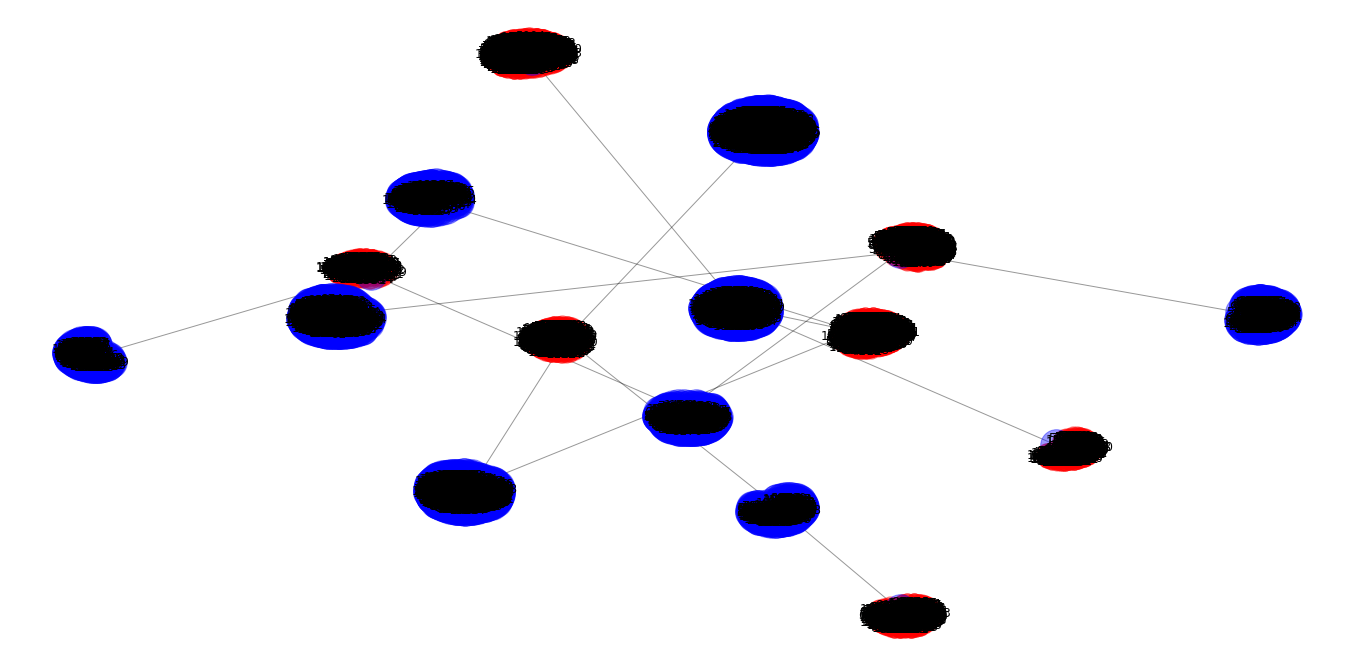

In [43]:
# Source node labels
graph = G
articles, topics = nx.bipartite.sets(graph)

# Plot graph by node type
# Apply plot settings
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (24,12)
plt.axis('off')
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, nodelist=articles, node_color='red', alpha = 0.4)
nx.draw_networkx_nodes(graph, pos, nodelist=topics, node_color='blue', alpha = 0.4, node_size = 1000)
nx.draw_networkx_edges(graph, pos, alpha = 0.4)
nx.draw_networkx_labels(graph, pos);

## Conclusion

## YouTube